# Homework 07: Ensemble Methods – Bagging, Random Forests, and Gradient Boosting

## Due: Midnight on March 16 (with 2-hour grace period) and worth 75 points

Over the past two weeks, we have expanded our machine learning toolkit by moving beyond linear regression to explore decision trees, which introduced a variety of interacting parameters. Through Homework 6, you developed a systematic workflow for parameter tuning that balances manual exploration and automated searches (e.g., random or grid search) to optimize performance while gaining insights into model behavior.

This week, we take another step forward by studying ensemble methods which combine multiple decision trees to produce even stronger predictive models. Specifically, we will investigate:

- Bagging  
- Random Forests  
- Gradient Boosting  

These three approaches build on the decision tree we studied last week. Our  workflow from Homework 6 will again serve as the foundation for optimizing these more complex models.

### What We Will Do in This Homework

To analyze and optimize our ensemble models, we will apply the two-phase strategy introduced in Homework 6 (but with grid search rather than random grid search):

1. **First Phase:**  
   - Iteratively sweep through key parameters in coarse ranges  
   - Visualize training, validation, and test MSE  
   - Diagnose overfitting or underfitting  
   - Examine the standard deviation of CV scores to understand model stability (review Problems 1 & 2 in Homework 6)

2. **Second Phase:**  
   - Focus on the most unstable or promising parameter ranges found in Phase 1  
   - Perform an exhaustive search within these narrower ranges using `GridSearchCV` (review Problem 4 in Homework 6)

Refer to **Appendix 4** for more details.

We will follow this process for each of the three ensemble methods, systematically tuning their four most important parameters:

1. **Bagging Regressor:** `n_estimators`, `max_samples`, `max_features`, `bootstrap`  
2. **Random Forest Regressor:** `n_estimators`, `max_depth`, `max_features`, `bootstrap`  
3. **Gradient Boosting Regressor:** `learning_rate`, `n_estimators`, `max_depth`, `max_features`

Throughout this homework, we will continue using `RepeatedKFold` cross-validation to reduce variance in our CV MSE estimates. The default number of repetitions is 10, but you may find it necessary to reduce this when initially searching broad parameter spaces—then increase it for fine-tuning as you zero-in on the best models. 

As before, you will store your best parameter values (and the resulting CV MSE) in a dictionary in order to track improvements across experiments and maintain a clear record of how each parameter choice was made.

Before starting:
- Review lesson materials on ensemble methods and watch the three videos on Bagging, Random Forests, and Gradient Boosting.  
- Study the relevant appendices.  
- Pay special attention to the Gradient Boosting video and notebook, as the code in this homework builds on (and has been adapted from) those resources.

### Grading

This homework consists of 15 graded problems, each worth 5 points, for a total of 75 points.

In [3]:
# Useful imports

import os
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import io
import zipfile
import time

from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold,GridSearchCV
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics         import mean_squared_error
from tqdm                    import tqdm

import matplotlib.ticker as mticker           # Optional: you can print out y axis labels as dollars. 

# globals

random_state = 42

# utility code

# Completely optional:  Format y-axis labels as dollars with commas
def dollar_format(x, pos):
    return f'${x:,.0f}'

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

### Load the Ames Housing Dataset  

The code cell below will load the dataset for you.  This is the same dataset we used for the last two homeworks. 

> **Notice** that this code includes a useful optimization: **before downloading, it first
checks whether the files already exist.** This is a essential step when working with large datasets or when building deep learning models, where training can span hours or even days. By reusing previously downloaded files or saved models, you can avoid unnecessary work and significantly speed up your workflow.

For a detailed description of the dataset features, please refer to the **Appendix** in Homework 05. 

In [4]:
data_dir = "Ames_Dataset"                              # Directory where files will be stored

# Check if one of the files exists; if not, download and extract the zip file

if not os.path.exists( os.path.join(data_dir, "X_train.csv") ):
    print("Dataset files not found. Downloading...")
    zip_url = "https://www.cs.bu.edu/fac/snyder/cs505/Data/ames_housing.zip"
    try:
        response = requests.get(zip_url)
        response.raise_for_status()  # Raise an error for bad status codes
        # Extract the zip file into the designated directory
        with zipfile.ZipFile(io.BytesIO(response.content)) as zipf:
            zipf.extractall(data_dir)
        print("Files downloaded and extracted successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
else:
    print("Dataset files already exist. Skipping download.")

# Load the datasets
X_train = pd.read_csv(os.path.join(data_dir, "X_train.csv"))
X_test  = pd.read_csv(os.path.join(data_dir, "X_test.csv"))
y_train = pd.read_csv(os.path.join(data_dir, "y_train.csv")).squeeze("columns")    
y_test  = pd.read_csv(os.path.join(data_dir, "y_test.csv")).squeeze("columns")

print("Training and testing datasets loaded successfully.")


Dataset files already exist. Skipping download.
Training and testing datasets loaded successfully.


## Prelude: Wrapper Functions for Running Ensemble Models

The following cells are adapted from the Week 7 video notebook on `GradientBoostingRegressor`, but have been refactored so that they can handle any of the three ensemble models (Bagging, Random Forest, or Gradient Boosting). Key changes include:

- **`run_model`** replaces the original `run_gradient_boosting_regressor` and accepts a parameter dictionary that can be applied to any of the three ensemble models.  
- **`sweep_parameter`** is updated to work seamlessly with `run_model`, letting you:
  - Specify which ensemble model you want to use.  
  - Pass a dictionary of model parameters.  
  - Return a modified parameter dictionary reflecting the best value of the parameter you swept, along with the corresponding MSE  (note that RMSE is **only** used for printing out results)

> **Note:** Please do not change these cells unless you consult with the LFs first. Any alterations may cause downstream issues with the assignment.

In [143]:
def run_model(model, X_train, y_train, X_test, y_test, n_repeats=10, n_jobs=-1, **model_params):

    # Instantiate the model if a class is provided, so for example can use either BaggingRegressor or BaggingRegressor() as argument. 
    if isinstance(model, type):
        model = model(**model_params)

    neg_mse_scores = cross_val_score(model, X_train, y_train,scoring = 'neg_mean_squared_error',
                                     cv = RepeatedKFold(n_splits=5, n_repeats=n_repeats, random_state=42), n_jobs  = n_jobs)
    
    mean_cv_mse = -np.mean(neg_mse_scores)
    std_cv_mse  = np.std(neg_mse_scores)
    
    # Fit the model on the full training set
    model.fit(X_train, y_train)
    
    # Compute training MSE and testing MSE
    train_preds = model.predict(X_train)
    train_mse   = mean_squared_error(y_train, train_preds)
    test_preds  = model.predict(X_test)
    test_mse    = mean_squared_error(y_test, test_preds)
    
    return mean_cv_mse, std_cv_mse, train_mse, test_mse


In [144]:
def sweep_parameter(model,
                    Parameters,
                    param,
                    parameter_list,
                    X_train          = X_train,
                    y_train          = y_train,
                    X_test           = X_test,
                    y_test           = y_test,
                    verbose          = True,
                    show_rmse        = True,
                    n_iter_no_change = None,
                    delta            = 0.001,
                    n_jobs           = -1,
                    n_repeats        = 10):
    
    start = time.time()
    Parameters = Parameters.copy()  # Avoid modifying the original dictionary
    
    cv_mses, std_cvs, train_mses, test_mses = [], [], [], []
    no_improve_count = 0
    best_mse = float('inf')
    
    # Run over each value in parameter_list
    for p in tqdm(parameter_list, desc=f"Sweeping {param}"):
        Parameters[param] = p
        P_temp = Parameters.copy()
        # Remove MSE_found if present, just in case
        P_temp.pop('MSE_found', None)
        
        cv_mse, std_cv, train_mse, test_mse = run_model(
            model=model,
            X_train=X_train, y_train=y_train,
            X_test=X_test,   y_test=y_test,
            n_repeats=n_repeats,
            n_jobs=n_jobs,
            **P_temp
        )
        cv_mses.append(cv_mse)
        std_cvs.append(std_cv)
        train_mses.append(train_mse)
        test_mses.append(test_mse)
        
        # Early-stopping logic
        if cv_mse < best_mse - delta:
            best_mse = cv_mse
            no_improve_count = 0
        else:
            no_improve_count += 1
        
        if n_iter_no_change is not None and no_improve_count >= n_iter_no_change:
            print(f"Early stopping: No improvement after {n_iter_no_change} iterations.")
            break
    
    # Identify best parameter
    min_cv_mse = min(cv_mses)
    min_index = cv_mses.index(min_cv_mse)
    best_param = parameter_list[min_index]
    Parameters[param] = best_param
    Parameters['MSE_found'] = min_cv_mse
    
    if verbose:
        # Prepare for plotting
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
        
        # We only need as many parameter values as we actually computed
        partial_param_list = parameter_list[:len(cv_mses)]
        
        # Check if our parameter list is Boolean so we can label accordingly
        is_boolean = all(isinstance(val, bool) for val in partial_param_list)
        if is_boolean:
            # Convert booleans to integer indices for plotting
            x_vals = list(range(len(partial_param_list)))
            x_labels = [str(val) for val in partial_param_list]
        else:
            # Treat numeric or other types as-is
            x_vals = partial_param_list
            x_labels = partial_param_list
        
        error_name = 'RMSE' if show_rmse else 'MSE'
        
        # ----- First plot: (R)MSE -----
        ax1.set_title(f"{error_name} vs {param}")
        
        # Apply dollar formatting ONLY if we're showing RMSE
        if show_rmse:
            ax1.yaxis.set_major_formatter(mticker.FuncFormatter(dollar_format))
        
        # Plot lines
        ax1.plot(x_vals,
                 np.sqrt(cv_mses) if show_rmse else cv_mses,
                 marker='.', label=f"CV {error_name}", color='blue')
        ax1.plot(x_vals,
                 np.sqrt(train_mses) if show_rmse else train_mses,
                 marker='.', label=f"Train {error_name}", color='green')
        ax1.plot(x_vals,
                 np.sqrt(test_mses) if show_rmse else test_mses,
                 linestyle='--', label=f"Test {error_name}", color='orange')
        ax1.scatter([x_vals[min_index]],
                    [np.sqrt(min_cv_mse) if show_rmse else min_cv_mse],
                    marker='x', label=f"Best CV {error_name}", color='red')
        
        ax1.set_ylabel(error_name)
        ax1.legend()
        ax1.grid()
        
        # ----- Second plot: CV Std Dev -----
        ax2.set_title(f"CV Standard Deviation vs {param}")
        ax2.plot(x_vals, std_cvs, marker='.', label=f"CV {error_name} Std", color='blue')
        ax2.set_xlabel(param)
        ax2.set_ylabel("Standard Deviation")
        ax2.legend()
        ax2.grid(alpha=0.5)
        
        # If we are using boolean x-values, set custom ticks
        if is_boolean:
            ax2.set_xticks(x_vals)
            ax2.set_xticklabels(x_labels)
        
        plt.tight_layout()
        plt.show()
        
        end = time.time()
        print("Execution Time:", time.strftime("%H:%M:%S", time.gmtime(end - start)))
    
    return Parameters


## **Problem One: Bagging Trees**  

In this problem, you will follow a structured workflow to tune and evaluate a **Bagging Regressor**. The process builds on the approach from the last two homeworks; note that, as Homework 06, we will apply **grid search** to systematically explore parameter values.  Note that we will **not** be used Early Stopping in this homework; this will be a valuable technique going forward, but in this homework we are still learning how these complex models perform.

At the end of the analysis, you will not simply select the model with the lowest CV MSE score. Instead, you will critically examine the plots to determine whether another model configuration provides a better balance between performance, stability, and generalization. This step is essential for ensuring that your chosen model will perform well on new data. The criteria we will use for this choice are in **Appendix 5** below. 

### **Part 1.A: Iteratively Sweep Parameters and Visualize Results using `sweep_parameter(...)`**  
We will start with the `Default_Parameters_Bagging` dictionary and iteratively adjust key parameters. At each step, using the code provided above, you will:  

- Test a range of values for the specified parameter.
- Plot training, repeated cross-validation, and test MSE to diagnose overfitting or underfitting.
- Plot the standard deviation of the CV scores to assess model stability.
- Store the best value (which produces the minimum CV MSE) in a dictionary, perhaps called `Parameters_BT`.

**You should read Appendix 4 now if you have not done so already.**

**Step-by-step process:**
1. **Sweep `n_estimators`** (integer values):  
   - Begin by *making a copy* of the provided `Default_Parameters_Bagging` dictionary.  
   - Sweep a range of **integer** values for `n_estimators` (the number of base learners).  
   - Store the best value in `Parameters_BT`. 

2. **Sweep `max_samples`** (float values):  
   - Using `Parameters_BT`, test a range of **float** values for `max_samples`.  
   - Store the best value in `Parameters_BT`. (*Note: This may simply be the default value!*)

3. **Sweep `max_features`** (integer values):  
   - Using `Parameters_BT`, test a range of **integer** values for `max_features`.  
   - Store the best value in `Parameters_BT`. (*Again, the best value might be the default!*)

4. **Sweep `bootstrap`** (Boolean values):  
   - Test both possible values (`True` and `False`).  
   - Store the best value in `Parameters_BT`.

5. **Report your final results (including all final parameter choices, and convert MSE to RMSE in dollars when printing out)** and answer the graded question. 

In [145]:
# Define the parameters for the BaggingRegressor
Default_Parameters_Bagging = {
    'n_estimators': 10,            # Number of base estimators in the ensemble
    'max_samples' : 1.0,           # Fraction of samples to draw for each base estimator
    'max_features': 1.0,           # Fraction of features to consider for each estimator
    'bootstrap'   : True,          # Use bootstrap samples when building estimators
    'random_state': 42,            # Ensures reproducibility
    'MSE_found'   : float('inf')   # Used for tracking the best MSE during parameter sweeps, to record result of these parameter choices
                                   # Initialized to inf in case want to use this to record best MSE found so far in a sequence of parameter choices
}


Sweeping n_estimators: 100%|██████████| 6/6 [08:42<00:00, 87.10s/it]


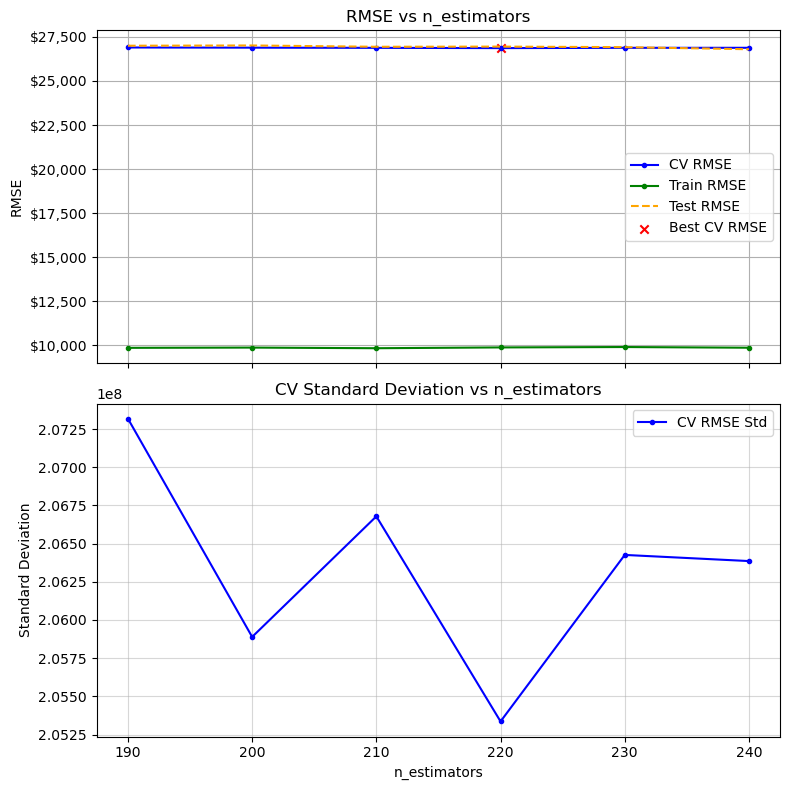

Execution Time: 00:08:43
Best RMSE 26863.13653294058
Best Parameters after sweeping n_estimators: {'n_estimators': 220, 'max_samples': 1.0, 'max_features': 1.0, 'bootstrap': True, 'random_state': 42, 'MSE_found': 721628104.387407}


In [36]:
# Your code here -- Add as many code cells as necessary

# Copy the default parameters
Parameters_BT = Default_Parameters_Bagging.copy()

# Define a range of values for n_estimators
n_estimators_list = np.arange(190, 250, 10)  

# Sweep n_estimators
Parameters_BT = sweep_parameter(
    model=BaggingRegressor,
    Parameters=Parameters_BT,
    param='n_estimators',
    parameter_list=n_estimators_list,
)

print("Best RMSE", Parameters_BT['MSE_found']**0.5)

print("Best Parameters after sweeping n_estimators:", Parameters_BT)



Sweeping max_samples: 100%|██████████| 5/5 [00:24<00:00,  4.94s/it]


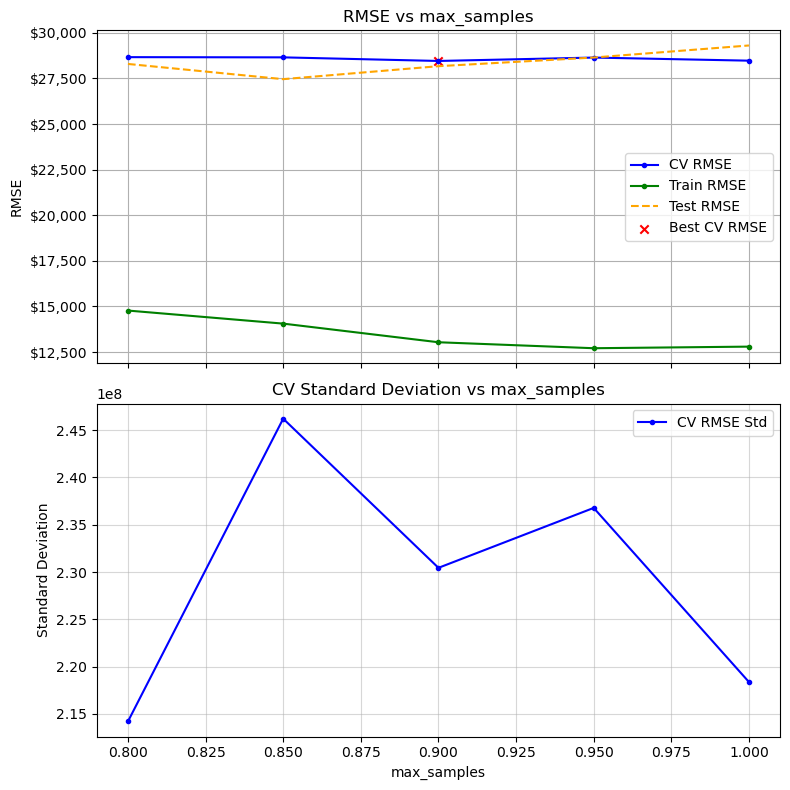

Execution Time: 00:00:25
Best RMSE 28460.909425323935
Best Parameters after sweeping max_samples: {'n_estimators': 10, 'max_samples': 0.9, 'max_features': 1.0, 'bootstrap': True, 'random_state': 42, 'MSE_found': 810023365.3164928}


In [39]:
# Copy the default parameters
Parameters_BT = Default_Parameters_Bagging.copy()

# Define a range of values for max_samples
max_samples_list = np.linspace(0.8, 1.0, 5)

# Sweep n_estimators
Parameters_BT = sweep_parameter(
    model=BaggingRegressor,
    Parameters=Parameters_BT,
    param='max_samples',
    parameter_list=max_samples_list,
)

print("Best RMSE", Parameters_BT['MSE_found']**0.5)

print("Best Parameters after sweeping max_samples:", Parameters_BT)


Sweeping max_features: 100%|██████████| 9/9 [00:23<00:00,  2.64s/it]


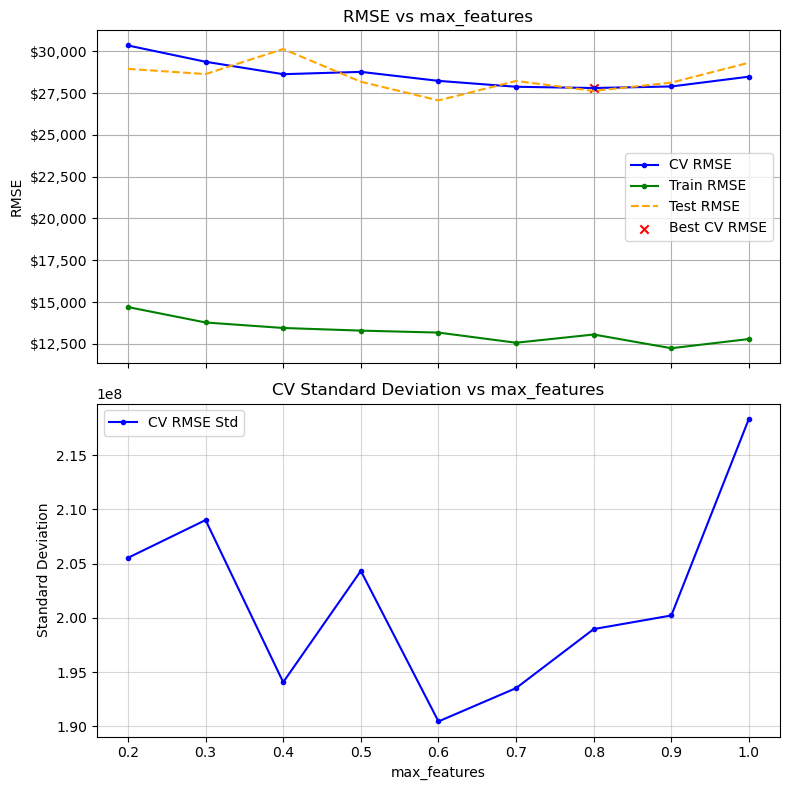

Execution Time: 00:00:24
Best RMSE 27798.549240559718
Best Parameters after sweeping max_features: {'n_estimators': 10, 'max_samples': 1.0, 'max_features': 0.8, 'bootstrap': True, 'random_state': 42, 'MSE_found': 772759339.8798232}


In [40]:
Parameters_BT = Default_Parameters_Bagging.copy()

# Define a range of values for max_features
max_features_list = np.linspace(0.2, 1.0, 9)

# Sweep n_estimators
Parameters_BT = sweep_parameter(
    model=BaggingRegressor,
    Parameters=Parameters_BT,
    param='max_features',
    parameter_list=max_features_list,
)

print("Best RMSE", Parameters_BT['MSE_found']**0.5)

print("Best Parameters after sweeping max_features:", Parameters_BT)

Sweeping bootstrap: 100%|██████████| 2/2 [00:10<00:00,  5.09s/it]


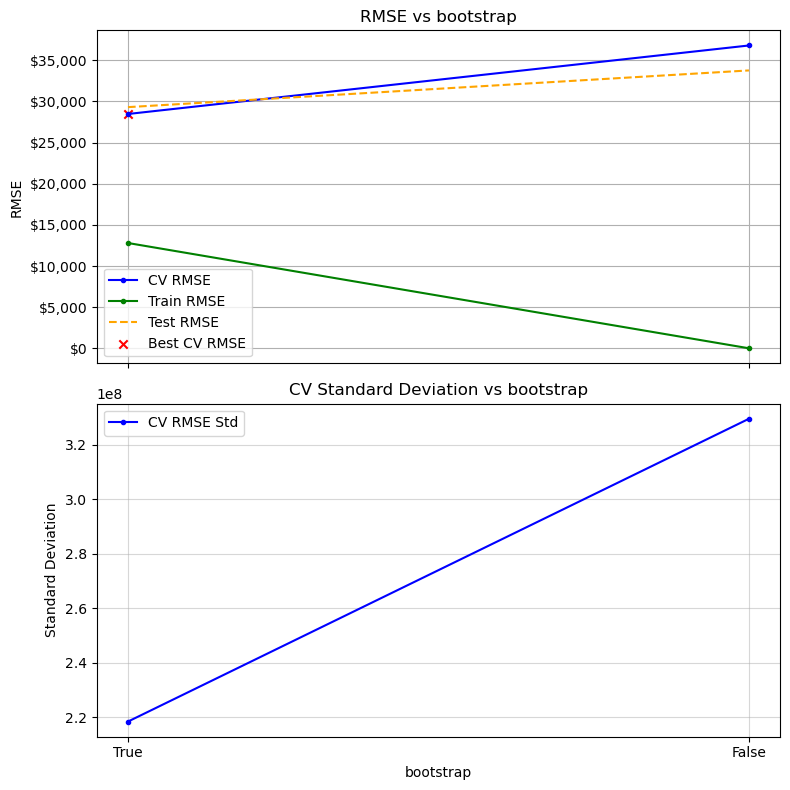

Execution Time: 00:00:10
Best RMSE 28477.019534419567
Best Parameters after sweeping bootstrap: {'n_estimators': 10, 'max_samples': 1.0, 'max_features': 1.0, 'bootstrap': True, 'random_state': 42, 'MSE_found': 810940641.5637136}


In [41]:
Parameters_BT = Default_Parameters_Bagging.copy()

# Define a range of values for bootstraps
bootstrap_list = [True, False]

# Sweep n_estimators
Parameters_BT = sweep_parameter(
    model=BaggingRegressor,
    Parameters=Parameters_BT,
    param='bootstrap',
    parameter_list=bootstrap_list,
)

print("Best RMSE", Parameters_BT['MSE_found']**0.5)

print("Best Parameters after sweeping bootstrap:", Parameters_BT)

Sweeping bootstrap: 100%|██████████| 2/2 [02:52<00:00, 86.41s/it]


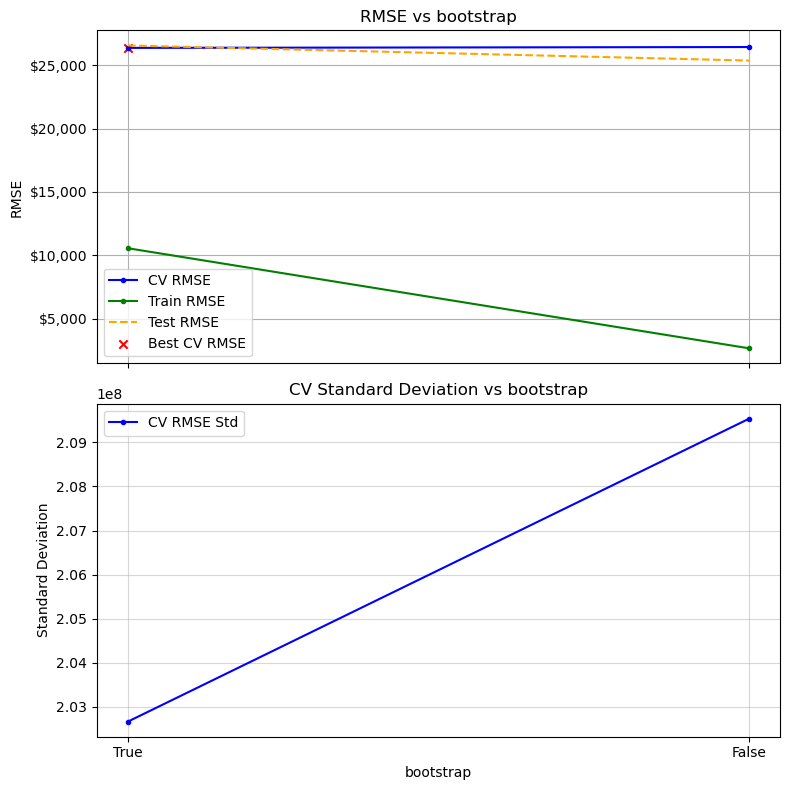

Execution Time: 00:02:53
Best RMSE 26353.494477239765
Best Parameters after sweeping bootstrap: {'n_estimators': 220, 'max_samples': 0.9, 'max_features': 0.8, 'bootstrap': True, 'random_state': 42, 'MSE_found': 694506671.1619067}


In [46]:
#use the final parameter choices, run the bootstrap again
Default_Parameters_Bagging_new = {
    'n_estimators': 220,            # Number of base estimators in the ensemble
    'max_samples' : 0.9,           # Fraction of samples to draw for each base estimator
    'max_features': 0.8,           # Fraction of features to consider for each estimator
    'bootstrap'   : True,          # Use bootstrap samples when building estimators
    'random_state': 42,            # Ensures reproducibility
    'MSE_found'   : float('inf')   # Used for tracking the best MSE during parameter sweeps, to record result of these parameter choices
                                   # Initialized to inf in case want to use this to record best MSE found so far in a sequence of parameter choices
}

Parameters_BT = Default_Parameters_Bagging_new.copy()

# Define a range of values for bootstraps
bootstrap_list = [True, False]

# Sweep n_estimators
Parameters_BT = sweep_parameter(
    model=BaggingRegressor,
    Parameters=Parameters_BT,
    param='bootstrap',
    parameter_list=bootstrap_list,
)

print("Best RMSE", Parameters_BT['MSE_found']**0.5)

print("Best Parameters after sweeping bootstrap:", Parameters_BT)


### Problem 1.A Graded Answer

In [146]:
# TODO:  Set the variable to best CV RMSE score found after Part A

a1a = 26353.494477239765                                # Just to get it to run without error; your answer here (remember to use the RMSE)         

print(f'a1a = ${a1a:,.2f}')              # Do not change this line, and DO NOT print anything else in this cell

a1a = $26,353.49


### **Part 1.B: Refine Parameters for Model Stability**  
After completing the first sweep, **repeat Part A as needed** to refine your model.  
- Your goal is to identify the parameter combination that minimizes the **CV MSE**.  
- **Final tuning goals:**
  - Adjust `n_estimators` with a **tolerance of 10**.
  - Adjust `max_samples` with a **tolerance of 0.1**.
  - Adjust `max_features` with a **tolerance of 1**.
- **Report your final results (including all final parameter choices, and convert MSE to RMSE in dollars when printing out)** and answer the graded question. 

Sweeping n_estimators: 100%|██████████| 3/3 [03:32<00:00, 70.82s/it]


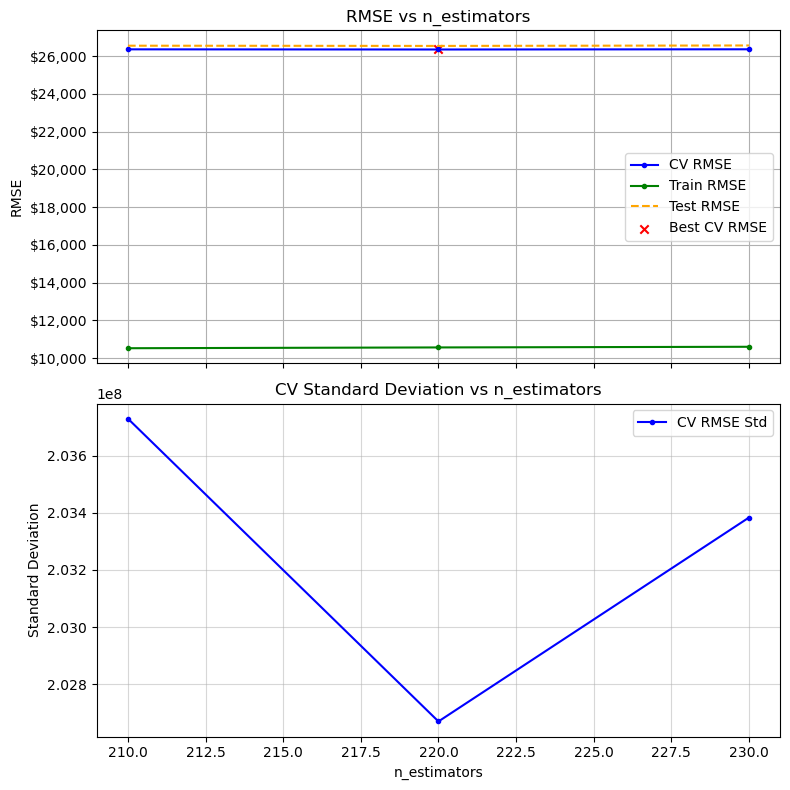

Execution Time: 00:03:32
Best RMSE 26353.494477239765
Best Parameters after sweeping n_estimators: {'n_estimators': 220, 'max_samples': 0.9, 'max_features': 0.8, 'bootstrap': True, 'random_state': 42, 'MSE_found': 694506671.1619067}


In [48]:
# Copy the default parameters
Parameters_BT = Default_Parameters_Bagging_new.copy()

# Define a range of values for n_estimators
n_estimators_list = np.arange(210, 240, 10)  

# Sweep n_estimators
Parameters_BT = sweep_parameter(
    model=BaggingRegressor,
    Parameters=Parameters_BT,
    param='n_estimators',
    parameter_list=n_estimators_list,
)

print("Best RMSE", Parameters_BT['MSE_found']**0.5)

print("Best Parameters after sweeping n_estimators:", Parameters_BT)

Sweeping max_samples: 100%|██████████| 3/3 [03:23<00:00, 67.80s/it]


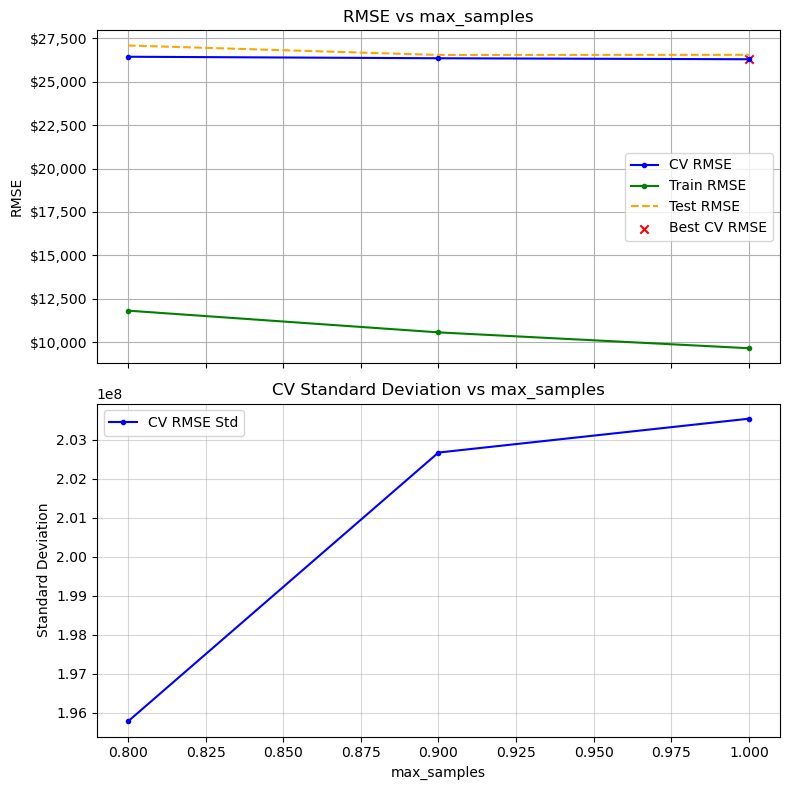

Execution Time: 00:03:23
Best RMSE 26296.00945885625
Best Parameters after sweeping max_samples: {'n_estimators': 220, 'max_samples': 1.0, 'max_features': 0.8, 'bootstrap': True, 'random_state': 42, 'MSE_found': 691480113.4602574}


In [50]:
# Copy the default parameters
Parameters_BT = Default_Parameters_Bagging_new.copy()

# Define a range of values for max_samples
max_samples_list = np.linspace(0.8, 1.0, 3)

# Sweep n_estimators
Parameters_BT = sweep_parameter(
    model=BaggingRegressor,
    Parameters=Parameters_BT,
    param='max_samples',
    parameter_list=max_samples_list,
)

print("Best RMSE", Parameters_BT['MSE_found']**0.5)

print("Best Parameters after sweeping max_samples:", Parameters_BT)

Sweeping max_features: 100%|██████████| 3/3 [03:26<00:00, 68.92s/it]


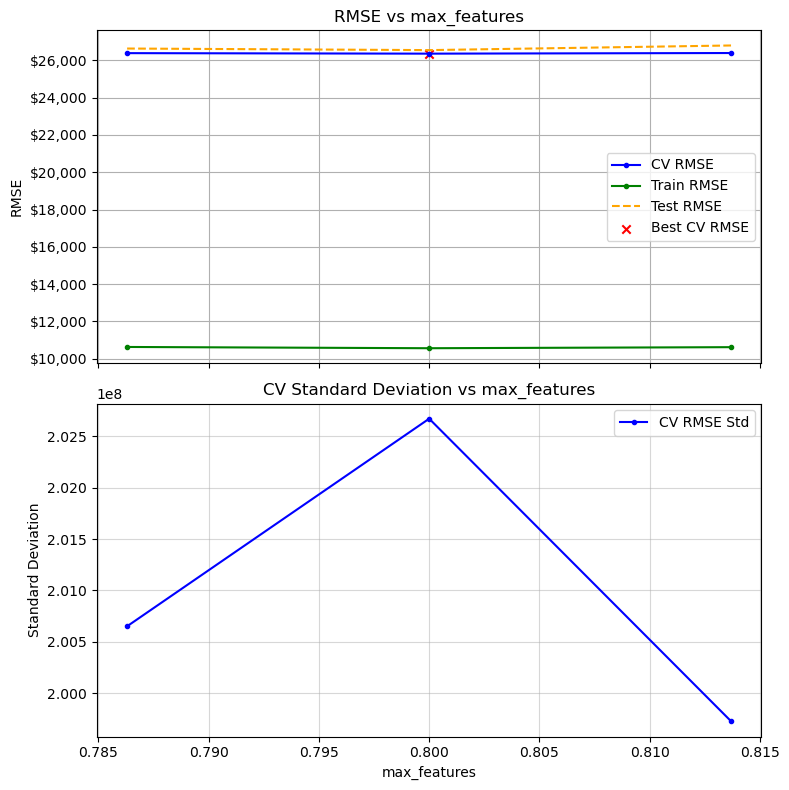

Execution Time: 00:03:27
Best RMSE 26353.494477239765
Best Parameters after sweeping max_features: {'n_estimators': 220, 'max_samples': 0.9, 'max_features': 0.8, 'bootstrap': True, 'random_state': 42, 'MSE_found': 694506671.1619067}


In [57]:
Parameters_BT = Default_Parameters_Bagging_new.copy()

# Define a range of values for max_features
features_number=X_train.shape[1]
current_feature_number=Default_Parameters_Bagging_new["max_features"]*features_number

max_features_list = [(current_feature_number-1)/features_number,(current_feature_number)/features_number, (current_feature_number+1)/features_number ]

# Sweep n_estimators
Parameters_BT = sweep_parameter(
    model=BaggingRegressor,
    Parameters=Parameters_BT,
    param='max_features',
    parameter_list=max_features_list,
)

print("Best RMSE", Parameters_BT['MSE_found']**0.5)

print("Best Parameters after sweeping max_features:", Parameters_BT)

### Problem 1.B Graded Answer

In [61]:
# TODO:  Set the variable to best CV RMSE score found after Part B (it may not be different than Part A)

a1b = 26296.00945885625                                # Just to get it to run without error; your answer here (remember to use the RMSE)          

print(f'a1b = ${a1b:,.2f}')              # Do not change this line, and DO NOT print anything else in this cell

a1b = $26,296.01


### **Part 1.C: Use `GridSearchCV` for Exhaustive Search**  
Once you have completed your parameter sweeps in Part B, you will verify and perhaps even refine your results using exhaustive grid search (not random search). 
- In your results from Part B, identify **unstable parameter ranges** (review Problem 4 from Homework 06).
- Perform  **exhaustive grid searches** within appropriately restricted ranges using `GridSearchCV`.  
- **Print out the best result found by exhaustive search (including the final parameter choices, and convert MSE to RMSE in dollars)** and answer the graded question.

NOTE: Do *not* simply redo all of Parts A and B, and you should repeat your grid search runs using the techniques described in Appendix 4 until you are sure you have either verified your results from Part B or found a model with an even lower CV MSE score than you found in Part B.   

In [70]:
# Your code here -- Add as many code cells as necessary

start=time.time()

# Define the model
bagging_model = BaggingRegressor(random_state=random_state)

# Define the parameter grid
param_grid = {
    'n_estimators': range(220, 300, 10),  # Include None and range 2-17
    # 'max_features': list(np.linspace(0.1, 1.0, 20))+[None],
    'max_features': np.linspace(0.1, 0.3, 10),
    'bootstrap': [True]
}



# Use GridSearchCV to find the best parameters
search = GridSearchCV(
    estimator=bagging_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # MSE but negated for maximization by GridSearchCV
    cv=RepeatedKFold(random_state=random_state),  # Use RepeatedKFold
    n_jobs=-1,  # Use all available cores
)


search.fit(X_train, y_train)

# Extract results into a DataFrame
results = pd.DataFrame(search.cv_results_)

# Sort results by mean_test_score (ascending order)
sorted_value = np.argsort(-results['mean_test_score'])

# Print the top 10 parameter combinations
for rank, index in enumerate(sorted_value[:10], start=1):
    parameter = results['params'][index]  # Use 'params' instead of 'parameter'
    mean_score = results['mean_test_score'][index]  # Convert back to positive MSE
    std_score = results['std_test_score'][index]
    rmse = np.sqrt(-mean_score)

    print(f"Rank {rank}: Parameters: {parameter}, Mean Test Score: {mean_score}, std: {std_score}, RMSE: {rmse:.4f}")

# End the timer
end = time.time()

# Print execution time
print(f"Execution Time: {end - start:.2f} seconds")

Rank 1: Parameters: {'bootstrap': True, 'max_features': 0.3, 'n_estimators': 260}, Mean Test Score: -707833034.0880308, std: 183242921.94588572, RMSE: 26605.1317
Rank 2: Parameters: {'bootstrap': True, 'max_features': 0.3, 'n_estimators': 280}, Mean Test Score: -707835527.7389919, std: 182386164.5089472, RMSE: 26605.1786
Rank 3: Parameters: {'bootstrap': True, 'max_features': 0.3, 'n_estimators': 270}, Mean Test Score: -708113937.3752198, std: 183206817.607061, RMSE: 26610.4103
Rank 4: Parameters: {'bootstrap': True, 'max_features': 0.3, 'n_estimators': 290}, Mean Test Score: -709229798.2920195, std: 183424005.91006282, RMSE: 26631.3687
Rank 5: Parameters: {'bootstrap': True, 'max_features': 0.3, 'n_estimators': 250}, Mean Test Score: -710036947.8770802, std: 182121123.76278323, RMSE: 26646.5185
Rank 6: Parameters: {'bootstrap': True, 'max_features': 0.3, 'n_estimators': 240}, Mean Test Score: -711046104.3552635, std: 182666843.17014867, RMSE: 26665.4478
Rank 7: Parameters: {'bootstrap

### Problem 1.C Graded Answer

In [147]:
# TODO:  Set the variable to best CV RMSE score found in Part C (it may not be different than Parts A and B)

a1c = 26605.1317                                # Just to get it to run without error; your answer here (remember to use the RMSE)           

print(f'a1c = ${a1c:,.2f}')              # Do not change this line, and DO NOT print anything else in this cell

a1c = $26,605.13


### **Part 1.D: Evaluate Model Generalization**  
At this point, you *may* have **two competing models**:  
1. The model found in **Part B** (from parameter sweeps).  
2. The model found in **Part C** (from `GridSearchCV`).  

To determine which model will **generalize best to new data**, **read Appendix 5** and carefully consider:
1. Does the **Part B model** perform best?
2. Does the **Part C model** (if different) generalize better?
3. Are there **additional insights from the plots** that suggest an alternative choice?  

If your decision is (3), choose the parameters by examination of the plots to build your best model for **Part E.** 
There is no precise algorithm for choosing a models by examination of plots, and this is the kind of "judgement call" that you will get better at as you gain experience with building complex models. 

Then answer the graded question and the non-graded question. 

### Problem 1.D Graded Answer

In [ ]:
# TODO:  Which of options 1, 2, or 3 did you choose?

a1d = 3                               # Should be integer 1, 2, or 3          

print(f'a1d = {a1d}')                    # Do not change this line, and DO NOT print anything else in this cell

a1d = Ellipsis


### Problem 1.D Non-Graded Answer but Please Do It

Describe in a couple of sentences how your examination of the plots led to your decision. (You'll be expected to answer many such questions when you do your project, so this is good practice, and I'll read as many of your answers as I can.)

Your answer: It is hard to tell which model is the best, as the differences is limited. I go wieh grid search result, because it consider more than one paramaters, and do it "automatically"






### **Part 1.E: Report the Test Score of the Best Model**  
Once you have selected the best model in **Part D**, report its **final test score** and answer the graded question.   


In [89]:
# Run your best model here on the test data and print out the resulting test RMSE. 
final_parameters = {
    'n_estimators': 260,            # Number of base estimators in the ensemble
    'max_samples' : 0.85,           # Fraction of samples to draw for each base estimator
    'max_features': 0.3,           # Fraction of features to consider for each estimator
    'bootstrap'   : True,          # Use bootstrap samples when building estimators
    'random_state': 42,            # Ensures reproducibility
    # 'MSE_found'   : float('inf')   # Used for tracking the best MSE during parameter sweeps, to record result of these parameter choices
                                   # Initialized to inf in case want to use this to record best MSE found so far in a sequence of parameter choices
}

_,_,_,test_MSE=run_model(BaggingRegressor, X_train, y_train, X_test, y_test, n_repeats=1, n_jobs=-1, **final_parameters)

RMSE=test_MSE**0.5
print(f"RMSE = ${RMSE:.2f}")



RMSE = $27193.18


### Problem 1.E Graded Answer

In [148]:
# TODO:  Assign the variable to the test RMSE of the model you selected in Part E

a1e = 27193.18                                # Just to get it to run without error; your answer here  (be sure to use the RMSE)         

print(f'a1e = ${a1e:,.2f}')              # Do not change this line, and DO NOT print anything else in this cell

a1e = $27,193.18


## Problem Two: Random Forests

Now you will do the exact same thing as in Problem One, but for `RandomForestRegressor`. 
(Instructions are omitted, refer to them above.) 

### **Part 2.A: Iteratively Sweep Parameters and Visualize Results using `sweep_parameter(...)`**  

In [149]:
# Define the parameters for the Random Forest

Default_Parameters_Random_Forests = {
    'n_estimators': 100,         # Number of base estimators in the ensemble
    'max_features': None,        # Number of features to consider when looking for the best split 
    'max_depth'   : None,        # Limits the depth of each tree
    'bootstrap'   : True,        # Use bootstrap samples when building estimators
    'random_state': 42,          # Ensures reproducibility
    'MSE_found'   : float('inf') # Used for tracking the best MSE during parameter sweeps, to record result of these parameter choices
                                 # Initialized to inf in case want to use this to record best MSE found so far in a sequence of parameter choices
}

Sweeping n_estimators: 100%|██████████| 10/10 [17:36<00:00, 105.60s/it]


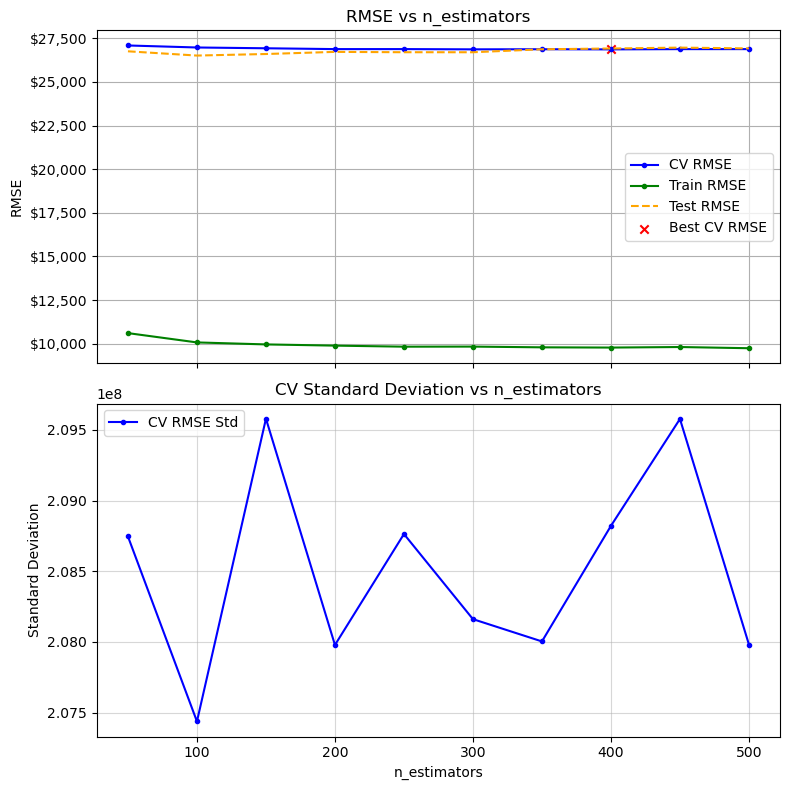

Execution Time: 00:17:36
Best RMSE 26862.54001939007
Best Parameters after sweeping n_estimators: {'n_estimators': 400, 'max_features': None, 'max_depth': None, 'bootstrap': True, 'random_state': 42, 'MSE_found': 721596056.2933332}


In [93]:
# Copy the default parameters
Parameters_RF = Default_Parameters_Random_Forests.copy()

# Define a range of values for n_estimators
n_estimators_list = np.arange(50, 501, 50)  

# Sweep n_estimators
Parameters_RF = sweep_parameter(
    model=RandomForestRegressor,
    Parameters=Parameters_RF,
    param='n_estimators',
    parameter_list=n_estimators_list,
)

print("Best RMSE", Parameters_RF['MSE_found']**0.5)

print("Best Parameters after sweeping n_estimators:", Parameters_RF)

Sweeping max_features: 100%|██████████| 7/7 [02:41<00:00, 23.06s/it]


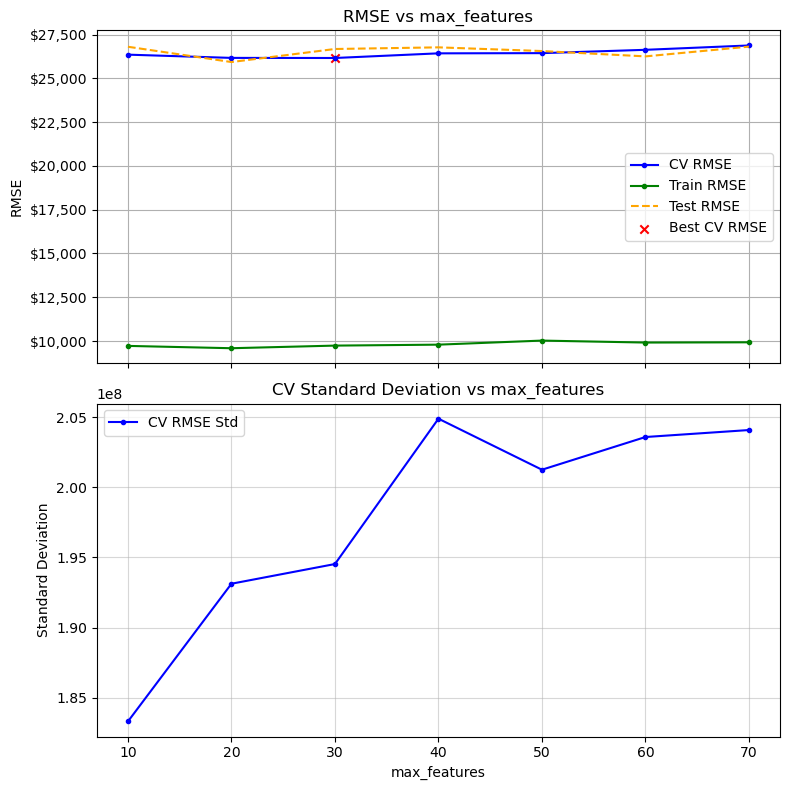

Execution Time: 00:02:41
Best RMSE 26159.56819693744
Best Parameters after sweeping max_features: {'n_estimators': 100, 'max_features': 30, 'max_depth': None, 'bootstrap': True, 'random_state': 42, 'MSE_found': 684323008.2502207}


In [94]:
# Copy the default parameters
Parameters_RF = Default_Parameters_Random_Forests.copy()

n_features = X_train.shape[1]

# Define a range of values for n_estimators
max_features_list = np.arange(10, n_features, 10)  

# Sweep n_estimators
Parameters_RF = sweep_parameter(
    model=RandomForestRegressor,
    Parameters=Parameters_RF,
    param='max_features',
    parameter_list=max_features_list,
)

print("Best RMSE", Parameters_RF['MSE_found']**0.5)

print("Best Parameters after sweeping max_features:", Parameters_RF)


Sweeping max_depth: 100%|██████████| 10/10 [07:02<00:00, 42.27s/it]


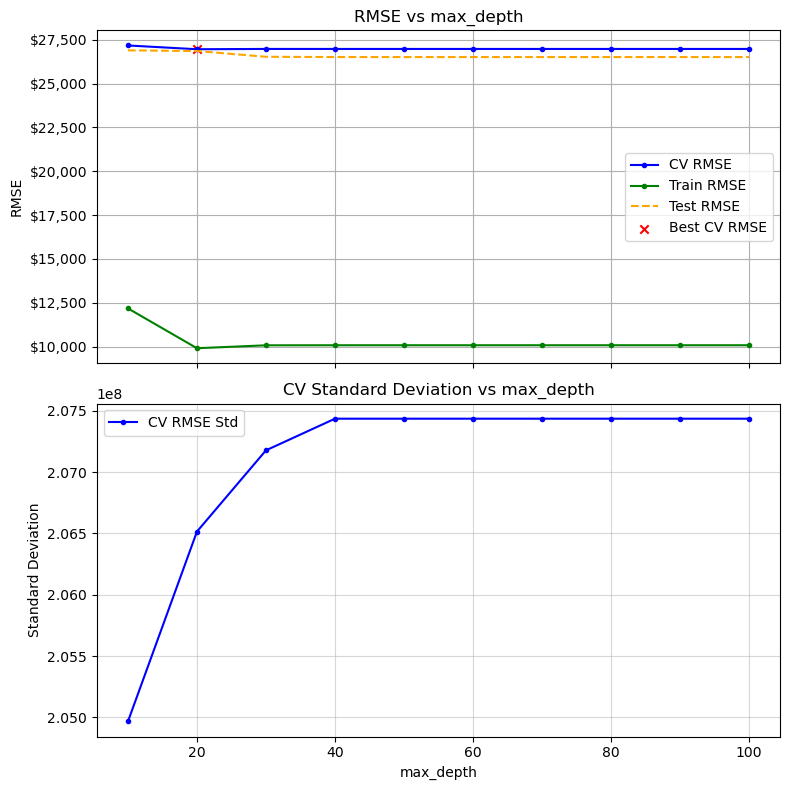

Execution Time: 00:07:03
Best RMSE 26954.556878664862
Best Parameters after sweeping max_depth: {'n_estimators': 100, 'max_features': None, 'max_depth': 20, 'bootstrap': True, 'random_state': 42, 'MSE_found': 726548136.5251793}


In [95]:
# Copy the default parameters
Parameters_RF = Default_Parameters_Random_Forests.copy()

# Define a range of values for n_estimators
max_depth_list = np.arange(10, 101, 10)  

# Sweep n_estimators
Parameters_RF = sweep_parameter(
    model=RandomForestRegressor,
    Parameters=Parameters_RF,
    param='max_depth',
    parameter_list=max_depth_list,
)

print("Best RMSE", Parameters_RF['MSE_found']**0.5)

print("Best Parameters after sweeping max_depth:", Parameters_RF)

Sweeping bootstrap: 100%|██████████| 2/2 [01:53<00:00, 56.81s/it]


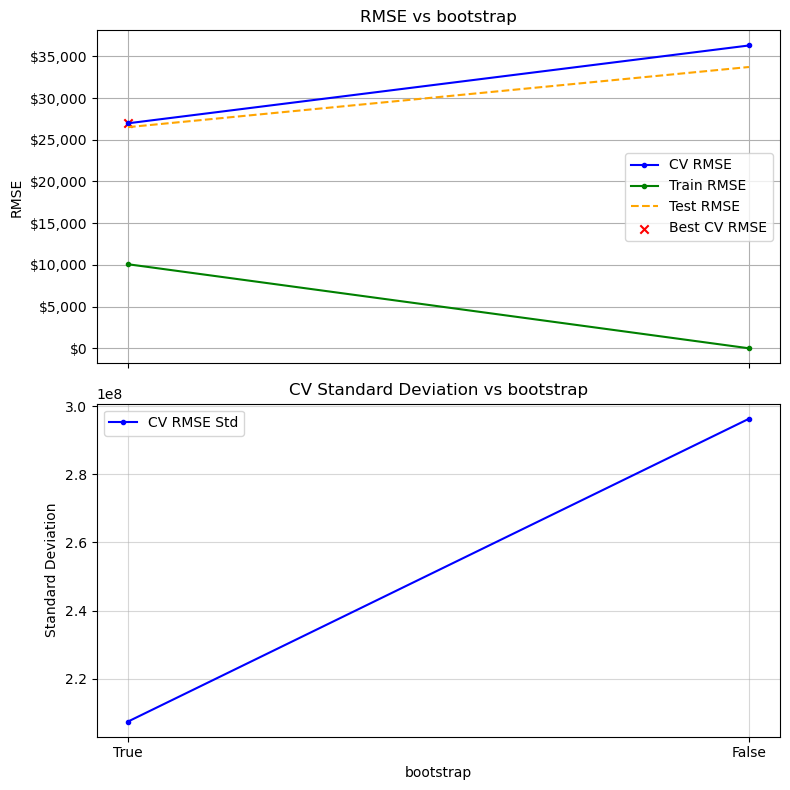

Execution Time: 00:01:54
Best RMSE 26971.3882826105
Best Parameters after sweeping bootstrap: {'n_estimators': 100, 'max_features': None, 'max_depth': None, 'bootstrap': True, 'random_state': 42, 'MSE_found': 727455785.8913391}


In [96]:
# Copy the default parameters
Parameters_RF = Default_Parameters_Random_Forests.copy()

# Define a range of values for n_estimators
bootstrap_list = [True, False] 

# Sweep n_estimators
Parameters_RF = sweep_parameter(
    model=RandomForestRegressor,
    Parameters=Parameters_RF,
    param='bootstrap',
    parameter_list=bootstrap_list,
)

print("Best RMSE", Parameters_RF['MSE_found']**0.5)

print("Best Parameters after sweeping bootstrap:", Parameters_RF)

In [ ]:
# Copy the default parameters
Parameters_RF = Default_Parameters_Random_Forests.copy()

# Define a range of values for n_estimators
n_estimators_list = np.arange(190, 250, 10)  

# Sweep n_estimators
Parameters_RF = sweep_parameter(
    model=RandomForestRegressor,
    Parameters=Parameters_RF,
    param='n_estimators',
    parameter_list=n_estimators_list,
)

print("Best RMSE", Parameters_RF['MSE_found']**0.5)

print("Best Parameters after sweeping n_estimators:", Parameters_RF)

### Problem 2.A Graded Answer

In [152]:
# TODO:  Set the variable to best CV RMSE score found after Part 2.A

a2a = 26159.56819693744                                # Just to get it to run without error; your answer here (remember to use the RMSE)         

print(f'a2a = ${a2a:,.2f}')              # Do not change this line, and DO NOT print anything else in this cell

a2a = $26,159.57


### **Part 2.B: Refine Parameters for Model Stability**  


Sweeping n_estimators: 100%|██████████| 4/4 [10:13<00:00, 153.30s/it]


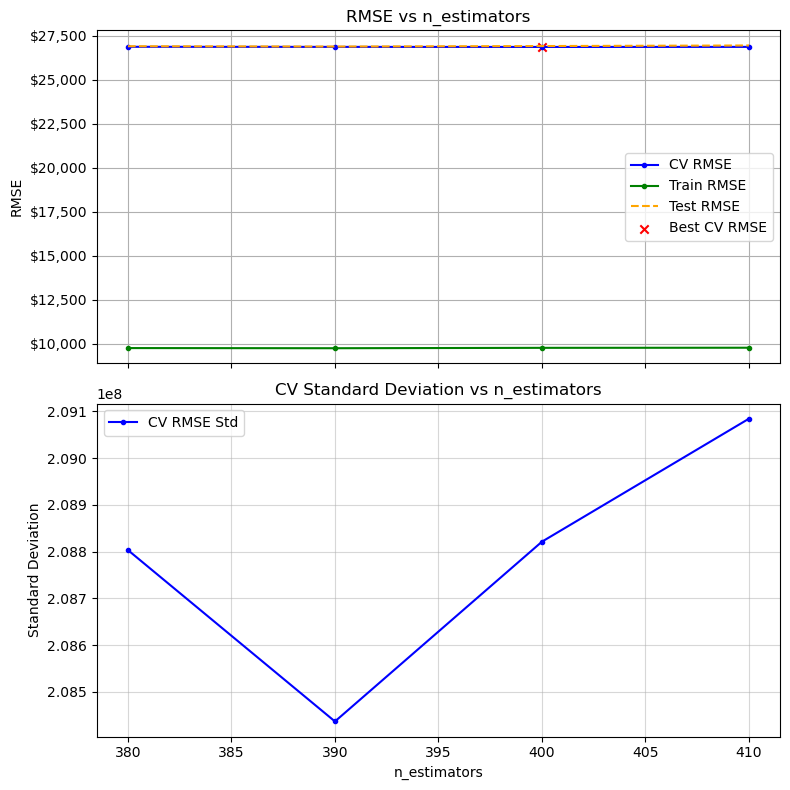

Execution Time: 00:10:13
Best RMSE 26862.54001939007
Best Parameters after sweeping n_estimators: {'n_estimators': 400, 'max_features': None, 'max_depth': None, 'bootstrap': True, 'random_state': 42, 'MSE_found': 721596056.2933332}


In [103]:
# Your code here -- Add as many code cells as necessary

# Copy the default parameters
Parameters_RF = Default_Parameters_Random_Forests.copy()

# Define a range of values for n_estimators
n_estimators_list = np.arange(380, 420, 10)  

# Sweep n_estimators
Parameters_RF = sweep_parameter(
    model=RandomForestRegressor,
    Parameters=Parameters_RF,
    param='n_estimators',
    parameter_list=n_estimators_list,
)

print("Best RMSE", Parameters_RF['MSE_found']**0.5)

print("Best Parameters after sweeping n_estimators:", Parameters_RF)


Sweeping max_features: 100%|██████████| 6/6 [01:49<00:00, 18.26s/it]


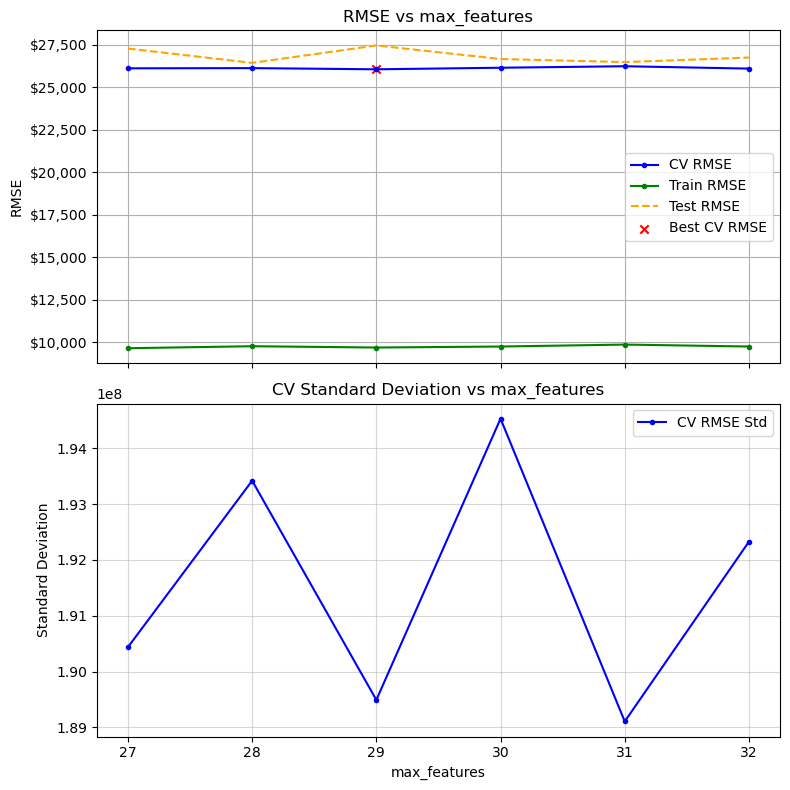

Execution Time: 00:01:49
Best RMSE 26067.17317245885
Best Parameters after sweeping max_features: {'n_estimators': 100, 'max_features': 29, 'max_depth': None, 'bootstrap': True, 'random_state': 42, 'MSE_found': 679497517.2029583}


In [104]:
# Copy the default parameters
Parameters_RF = Default_Parameters_Random_Forests.copy()

n_features = X_train.shape[1]

# Define a range of values for n_estimators
max_features_list = np.arange(27, 33, 1)  

# Sweep n_estimators
Parameters_RF = sweep_parameter(
    model=RandomForestRegressor,
    Parameters=Parameters_RF,
    param='max_features',
    parameter_list=max_features_list,
)

print("Best RMSE", Parameters_RF['MSE_found']**0.5)

print("Best Parameters after sweeping max_features:", Parameters_RF)


Sweeping max_depth: 100%|██████████| 14/14 [08:47<00:00, 37.70s/it]


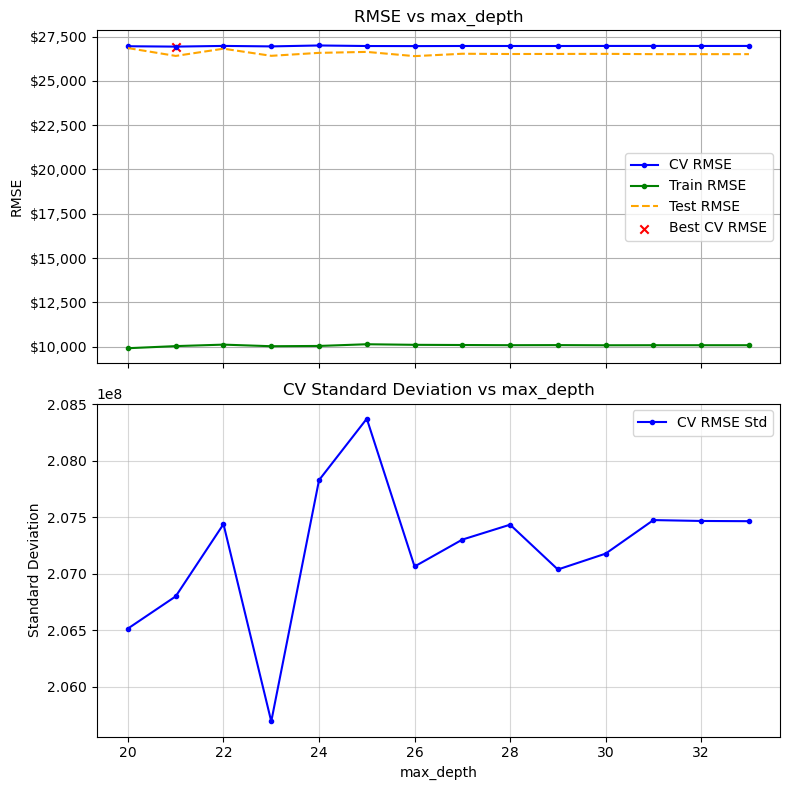

Execution Time: 00:08:48
Best RMSE 26934.27877036557
Best Parameters after sweeping max_depth: {'n_estimators': 100, 'max_features': None, 'max_depth': 21, 'bootstrap': True, 'random_state': 42, 'MSE_found': 725455372.8797655}


In [105]:
# Copy the default parameters
Parameters_RF = Default_Parameters_Random_Forests.copy()

# Define a range of values for n_estimators
max_depth_list = np.arange(20, 34, 1)  

# Sweep n_estimators
Parameters_RF = sweep_parameter(
    model=RandomForestRegressor,
    Parameters=Parameters_RF,
    param='max_depth',
    parameter_list=max_depth_list,
)

print("Best RMSE", Parameters_RF['MSE_found']**0.5)

print("Best Parameters after sweeping max_depth:", Parameters_RF)

### Problem 2.B Graded Answer

In [153]:
# TODO:  Set the variable to best CV RMSE score found after Part 2.B (it may not be different than Part 2.A)

a2b = 26067.17317245885                                # Just to get it to run without error; your answer here           

print(f'a2b = ${a2b:,.2f}')              # Do not change this line, and DO NOT print anything else in this cell

a2b = $26,067.17


### **Part 2.C: Use `GridSearchCV` for Exhaustive Search**  

In [154]:
# Your code here -- Add as many code cells as necessary

start=time.time()

# Define the model
RF_model = RandomForestRegressor(random_state=random_state)

# Define the parameter grid
param_grid = {
    'n_estimators': range(180, 240, 10), 
    'max_depth': [21],
    'max_features': range(27, 31, 1),
    'bootstrap': [True,False]
}

# Use GridSearchCV to find the best parameters
search = GridSearchCV(
    estimator=RF_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # MSE but negated for maximization by GridSearchCV
    cv=RepeatedKFold(random_state=random_state),  # Use RepeatedKFold
    n_jobs=-1,  # Use all available cores
)

search.fit(X_train, y_train)

# Extract results into a DataFrame
results = pd.DataFrame(search.cv_results_)

# Sort results by mean_test_score (ascending order)
sorted_value = np.argsort(-results['mean_test_score'])

# Print the top 10 parameter combinations
for rank, index in enumerate(sorted_value[:10], start=1):
    parameter = results['params'][index]  # Use 'params' instead of 'parameter'
    mean_score = results['mean_test_score'][index]  # Convert back to positive MSE
    std_score = results['std_test_score'][index]
    rmse = np.sqrt(-mean_score)

    print(f"Rank {rank}: Parameters: {parameter}, Mean Test Score: {mean_score}, std: {std_score}, RMSE: {rmse:.4f}")

# End the timer
end = time.time()

# Print execution time
print(f"Execution Time: {end - start:.2f} seconds")


Rank 1: Parameters: {'bootstrap': False, 'max_depth': 21, 'max_features': 27, 'n_estimators': 230}, Mean Test Score: -642191816.4799327, std: 188326027.9871495, RMSE: 25341.5038
Rank 2: Parameters: {'bootstrap': False, 'max_depth': 21, 'max_features': 27, 'n_estimators': 220}, Mean Test Score: -642993821.3219111, std: 187898312.6281631, RMSE: 25357.3228
Rank 3: Parameters: {'bootstrap': False, 'max_depth': 21, 'max_features': 27, 'n_estimators': 210}, Mean Test Score: -643689980.548454, std: 188368063.67837918, RMSE: 25371.0461
Rank 4: Parameters: {'bootstrap': False, 'max_depth': 21, 'max_features': 27, 'n_estimators': 200}, Mean Test Score: -643809522.7821025, std: 188120588.18525648, RMSE: 25373.4019
Rank 5: Parameters: {'bootstrap': False, 'max_depth': 21, 'max_features': 27, 'n_estimators': 180}, Mean Test Score: -644039764.6333586, std: 188857927.7932179, RMSE: 25377.9385
Rank 6: Parameters: {'bootstrap': False, 'max_depth': 21, 'max_features': 27, 'n_estimators': 190}, Mean Test

### Problem 2.C Graded Answer

In [155]:
# TODO:  Set the variable to best CV RMSE score found in Part C (it may not be different than Parts A and B)

a2c = 25341.5038                               # Just to get it to run without error; your answer here           

print(f'a2c = ${a2c:,.2f}')              # Do not change this line, and DO NOT print anything else in this cell

a2c = $25,341.50


### **Part 2.D: Evaluate Model Generalization**  


### Problem 2.D Graded Answer

In [138]:
# TODO:  Which of options 1, 2, or 3 did you choose?

a2d = 3                                # Should be integer 1, 2, or 3          

print(f'a2d = {a2d}')                    # Do not change this line, and DO NOT print anything else in this cell

a2d = 3


### Problem 2.D Non-Graded Answer but Please Do It

Describe in a couple of sentences how your examination of the plots led to your decision. (You'll be expected to answer many such questions when you do your project, so this is good practice, and I'll read as many of your answers as I can.)

Your Answer: It is hard to tell which model is the best, as the differences is limited. I go wieh grid search result, because it consider more than one paramaters, and do it "automatically"






### **Part 2.E: Report the Test Score of the Best Model**  
Once you have selected the best model, **report its final test score** and answer the graded question.   


In [156]:
# Run your best model here on the test data and print out the resulting test RMSE. 
final_parameters = {
    'n_estimators': 230,            # Number of base estimators in the ensemble
    'max_depth' : 21,           # Fraction of samples to draw for each base estimator
    'max_features': 27,           # Fraction of features to consider for each estimator
    'bootstrap'   : False,          # Use bootstrap samples when building estimators
    'random_state': 42,            # Ensures reproducibility
    # 'MSE_found'   : float('inf')   # Used for tracking the best MSE during parameter sweeps, to record result of these parameter choices
                                   # Initialized to inf in case want to use this to record best MSE found so far in a sequence of parameter choices
}

_,_,_,test_MSE=run_model(RandomForestRegressor, X_train, y_train, X_test, y_test, n_repeats=1, n_jobs=-1, **final_parameters)

RMSE=test_MSE**0.5
print(f"RMSE = ${RMSE:.2f}")


RMSE = $26039.95


### Problem 2.E Graded Answer

In [157]:
# TODO:  Assign the variable to the test RMSE of the model you selected in Part E

a2e = 26039.95                               # Just to get it to run without error; your answer here           

print(f'a2e = ${a2e:,.2f}')              # Do not change this line, and DO NOT print anything else in this cell

a2e = $26,039.95


## Problem Three: Gradient Boosting Trees

Now you will do the exact same thing as in Problem One, but for `GradientBoostingRegressor`. 
(Instructions are omitted, refer to them above.) 

### **Part 3.A: Iteratively Sweep Parameters and Visualize Results using `sweep_parameter(...)`**  

In [110]:
Default_Parameters_GradientBoosting = {
    'learning_rate'           : 0.1,             # Shrinks the contribution of each tree. Affects the speed of learning and overfitting.
    'n_estimators'            : 100,             # The number of boosting stages to be run. More estimators can improve performance but increase training time.
    'max_depth'               : 3,               # Maximum depth of individual trees. Controls model complexity.
    'max_features'            : None,            # Number of features to consider when looking for best split. Can help reduce overfitting.
    'random_state'            : 42,              # Controls randomness of boosting. Useful for reproducibility.
    'MSE_found'               : float('inf')     # NOT a parameter, but will record the MSE found for the current parameter choices
}


Sweeping learning_rate: 100%|██████████| 10/10 [01:43<00:00, 10.33s/it]


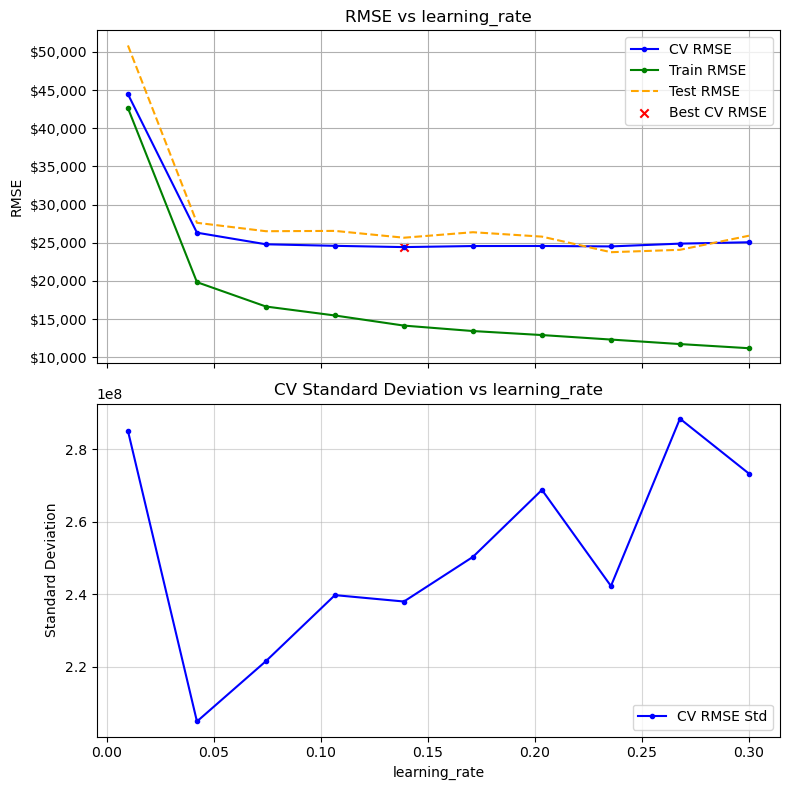

Execution Time: 00:01:43
Best RMSE 24434.99436679454
Best Parameters after sweeping learning_rate: {'learning_rate': 0.1388888888888889, 'n_estimators': 100, 'max_depth': 3, 'max_features': None, 'random_state': 42, 'MSE_found': 597068949.705281}


In [112]:
# Your code here -- Add as many code cells as necessary
# Copy the default parameters
Parameters_GB = Default_Parameters_GradientBoosting.copy()

# Define a range of values for n_estimators
learning_rate_list = np.linspace(0.01, 0.3, 10)

# Sweep n_estimators
Parameters_GB = sweep_parameter(
    model=GradientBoostingRegressor,
    Parameters=Parameters_GB,
    param='learning_rate',
    parameter_list=learning_rate_list,
)

print("Best RMSE", Parameters_GB['MSE_found']**0.5)

print("Best Parameters after sweeping learning_rate:", Parameters_GB)

Sweeping n_estimators: 100%|██████████| 10/10 [04:36<00:00, 27.64s/it]


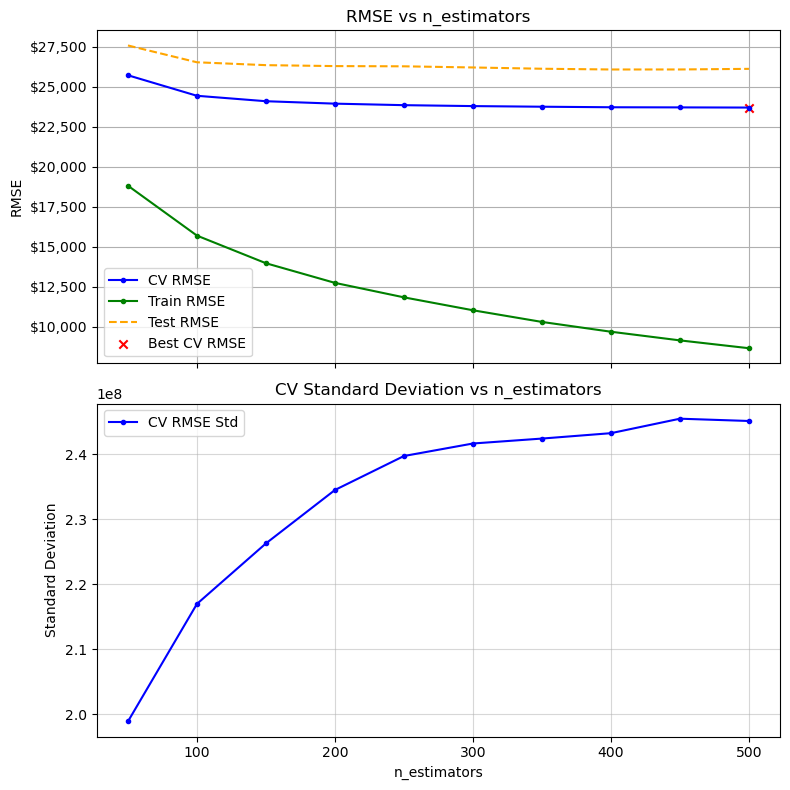

Execution Time: 00:04:36
Best RMSE 23702.12405335229
Best Parameters after sweeping n_estimators: {'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 3, 'max_features': None, 'random_state': 42, 'MSE_found': 561790684.6405013}


In [113]:
# Your code here -- Add as many code cells as necessary
# Copy the default parameters
Parameters_GB = Default_Parameters_GradientBoosting.copy()

# Define a range of values for n_estimators
n_estimators_list = np.arange(50, 501, 50)  

# Sweep n_estimators
Parameters_GB = sweep_parameter(
    model=GradientBoostingRegressor,
    Parameters=Parameters_GB,
    param='n_estimators',
    parameter_list=n_estimators_list,
)

print("Best RMSE", Parameters_GB['MSE_found']**0.5)

print("Best Parameters after sweeping n_estimators:", Parameters_GB)


Sweeping max_depth:   0%|          | 0/10 [00:00<?, ?it/s]

Sweeping max_depth: 100%|██████████| 10/10 [03:17<00:00, 19.77s/it]


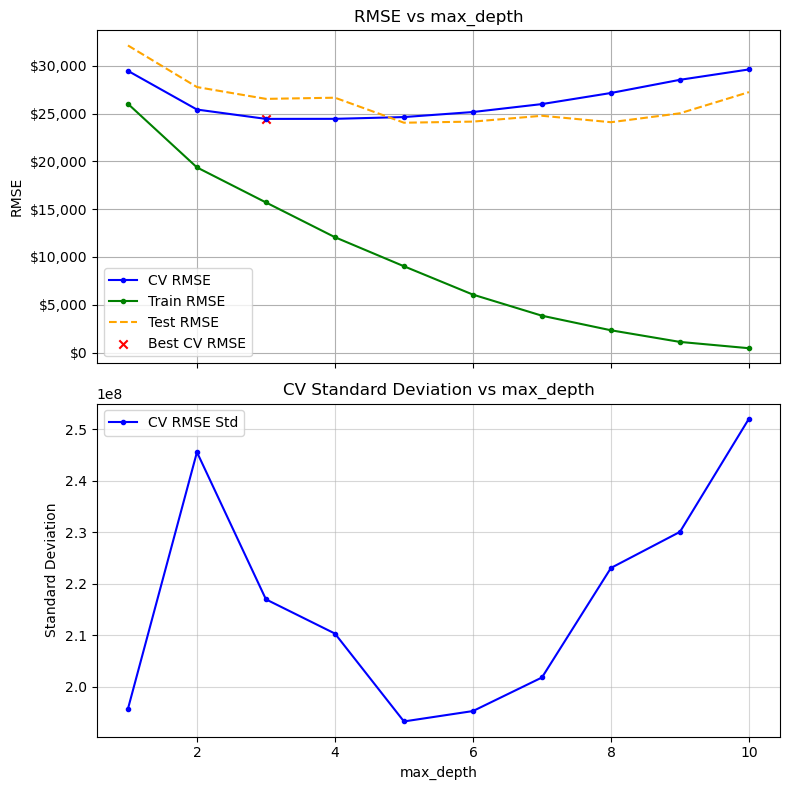

Execution Time: 00:03:18
Best RMSE 24438.312169184534
Best Parameters after sweeping max_depth: {'n_estimators': 100, 'max_features': None, 'max_depth': 3, 'random_state': 42, 'MSE_found': 597231101.6785129}


In [115]:
# Copy the default parameters
Parameters_GB = Default_Parameters_Random_Forests.copy()
Parameters_GB.pop('bootstrap', None)

# Define a range of values for max_depth
max_depth_list = np.arange(1, 11, 1)  

# Sweep n_estimators
Parameters_GB = sweep_parameter(
    model=GradientBoostingRegressor,
    Parameters=Parameters_GB,
    param='max_depth',
    parameter_list=max_depth_list,
)

print("Best RMSE", Parameters_GB['MSE_found']**0.5)

print("Best Parameters after sweeping max_depth:", Parameters_GB)

Sweeping max_features: 100%|██████████| 7/7 [04:20<00:00, 37.16s/it]


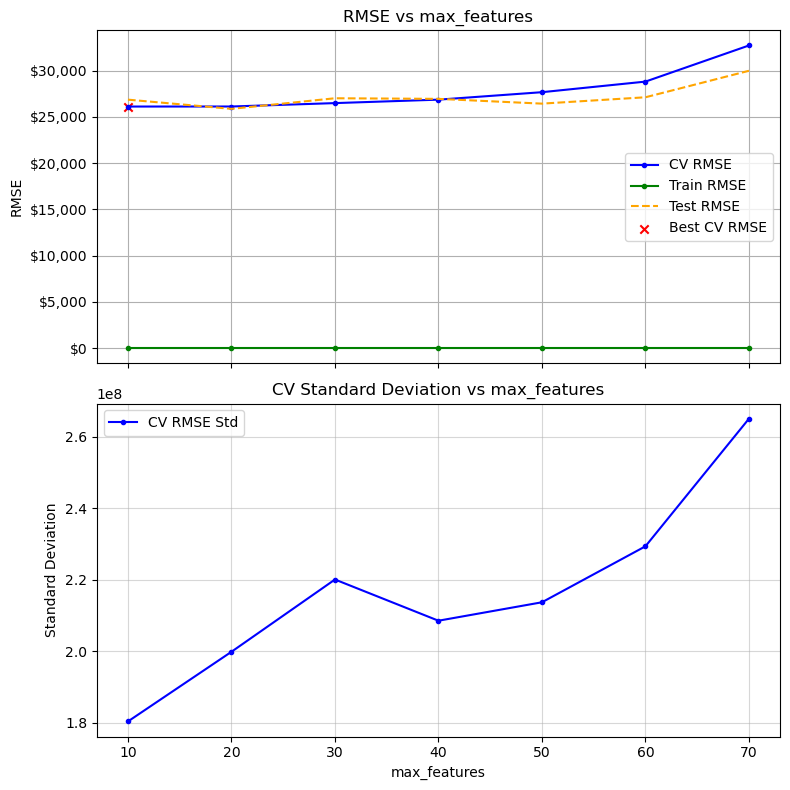

Execution Time: 00:04:20
Best RMSE 26114.655700568117
Best Parameters after sweeping max_features: {'n_estimators': 100, 'max_features': 10, 'max_depth': None, 'random_state': 42, 'MSE_found': 681975242.3592149}


In [122]:
# Copy the default parameters
Parameters_GB = Default_Parameters_Random_Forests.copy()
Parameters_GB.pop('bootstrap', None)

n_features = X_train.shape[1]

# Define a range of values for n_estimators
max_features_list = np.arange(10, n_features, 10)  

# Sweep n_estimators
Parameters_GB = sweep_parameter(
    model=GradientBoostingRegressor,
    Parameters=Parameters_GB,
    param='max_features',
    parameter_list=max_features_list,
)

print("Best RMSE", Parameters_GB['MSE_found']**0.5)

print("Best Parameters after sweeping max_features:", Parameters_GB)

### Problem 3.A Graded Answer

In [137]:
# TODO:  Set the variable to best CV RMSE score found after Part 3.A

a3a = 23702.12405335229                              # Just to get it to run without error; your answer here (remember to use the RMSE)         

print(f'a3a = ${a3a:,.2f}')              # Do not change this line, and DO NOT print anything else in this cell

a3a = $23,702.12


### **Part 3.B: Refine Parameters for Model Stability**  


Sweeping learning_rate: 100%|██████████| 10/10 [01:50<00:00, 11.06s/it]


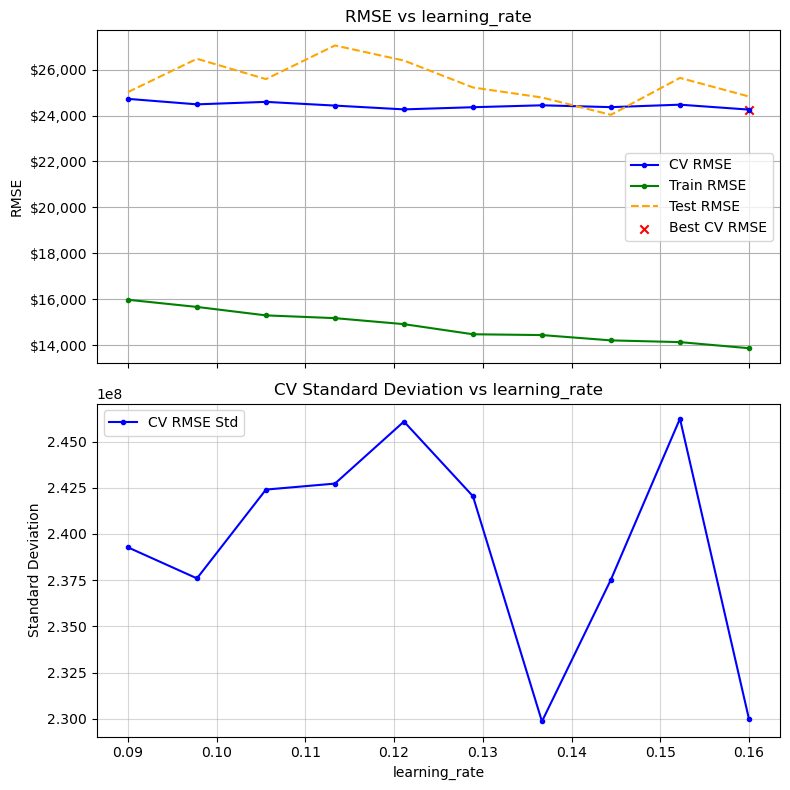

Execution Time: 00:01:51
Best RMSE 24257.19913610039
Best Parameters after sweeping learning_rate: {'learning_rate': 0.16, 'n_estimators': 100, 'max_depth': 3, 'max_features': None, 'random_state': 42, 'MSE_found': 588411709.9284295}


In [118]:
# Your code here -- Add as many code cells as necessary

# Copy the default parameters
Parameters_GB = Default_Parameters_GradientBoosting.copy()

# Define a range of values for n_estimators
learning_rate_list = np.linspace(0.09, 0.16, 10)

# Sweep n_estimators
Parameters_GB = sweep_parameter(
    model=GradientBoostingRegressor,
    Parameters=Parameters_GB,
    param='learning_rate',
    parameter_list=learning_rate_list,
)

print("Best RMSE", Parameters_GB['MSE_found']**0.5)

print("Best Parameters after sweeping learning_rate:", Parameters_GB)



Sweeping n_estimators: 100%|██████████| 11/11 [04:44<00:00, 25.88s/it]


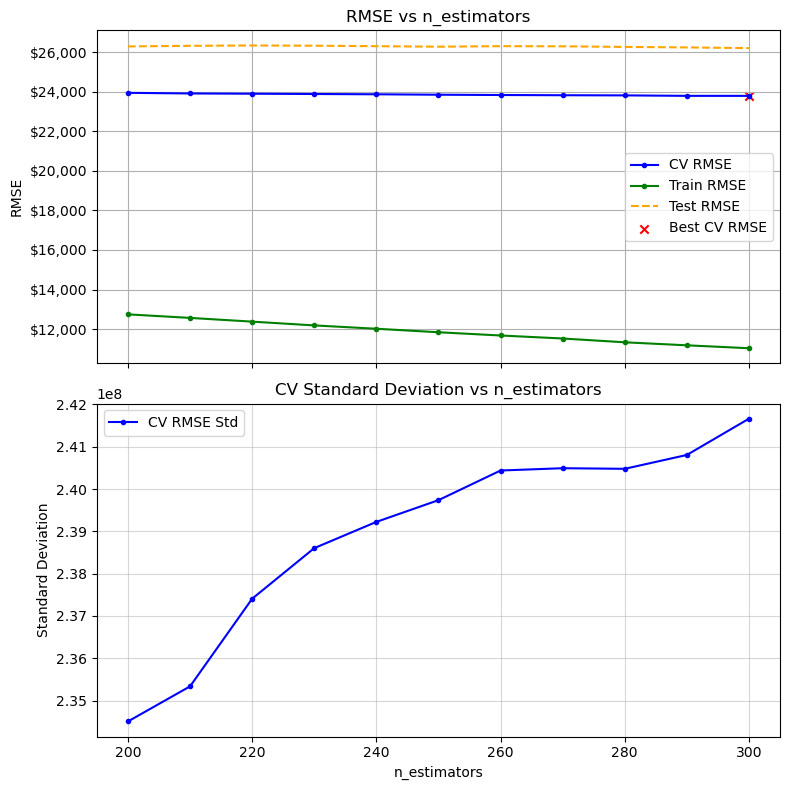

Execution Time: 00:04:45
Best RMSE 23794.08098801119
Best Parameters after sweeping n_estimators: {'learning_rate': 0.1, 'n_estimators': 300, 'max_depth': 3, 'max_features': None, 'random_state': 42, 'MSE_found': 566158290.0640355}


In [119]:
# Your code here -- Add as many code cells as necessary
# Copy the default parameters
Parameters_GB = Default_Parameters_GradientBoosting.copy()

# Define a range of values for n_estimators
n_estimators_list = np.arange(200, 301, 10)  

# Sweep n_estimators
Parameters_GB = sweep_parameter(
    model=GradientBoostingRegressor,
    Parameters=Parameters_GB,
    param='n_estimators',
    parameter_list=n_estimators_list,
)

print("Best RMSE", Parameters_GB['MSE_found']**0.5)

print("Best Parameters after sweeping n_estimators:", Parameters_GB)


Sweeping max_features: 100%|██████████| 36/36 [14:23<00:00, 23.98s/it]


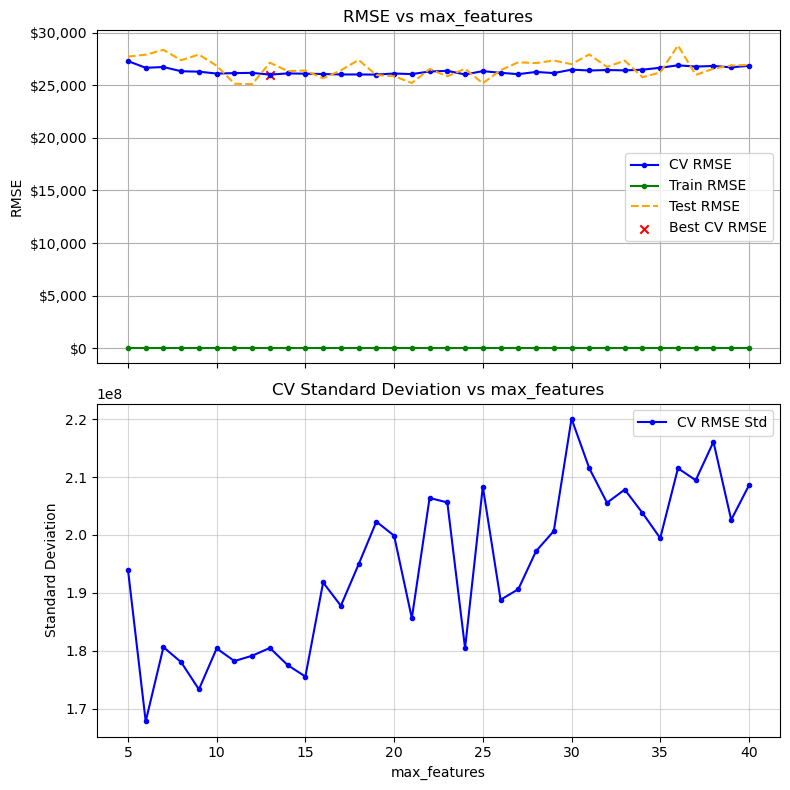

Execution Time: 00:14:23
Best RMSE 26015.299590814375
Best Parameters after sweeping max_features: {'n_estimators': 100, 'max_features': 13, 'max_depth': None, 'random_state': 42, 'MSE_found': 676795812.7998266}


In [125]:
# Copy the default parameters
Parameters_GB = Default_Parameters_Random_Forests.copy()
Parameters_GB.pop('bootstrap', None)


n_features = X_train.shape[1]

# Define a range of values for n_estimators
max_features_list = np.arange(5, 41, 1)  

# Sweep n_estimators
Parameters_GB = sweep_parameter(
    model=GradientBoostingRegressor,
    Parameters=Parameters_GB,
    param='max_features',
    parameter_list=max_features_list,
)

print("Best RMSE", Parameters_GB['MSE_found']**0.5)

print("Best Parameters after sweeping max_features:", Parameters_GB)

Sweeping max_depth: 100%|██████████| 4/4 [00:39<00:00,  9.81s/it]


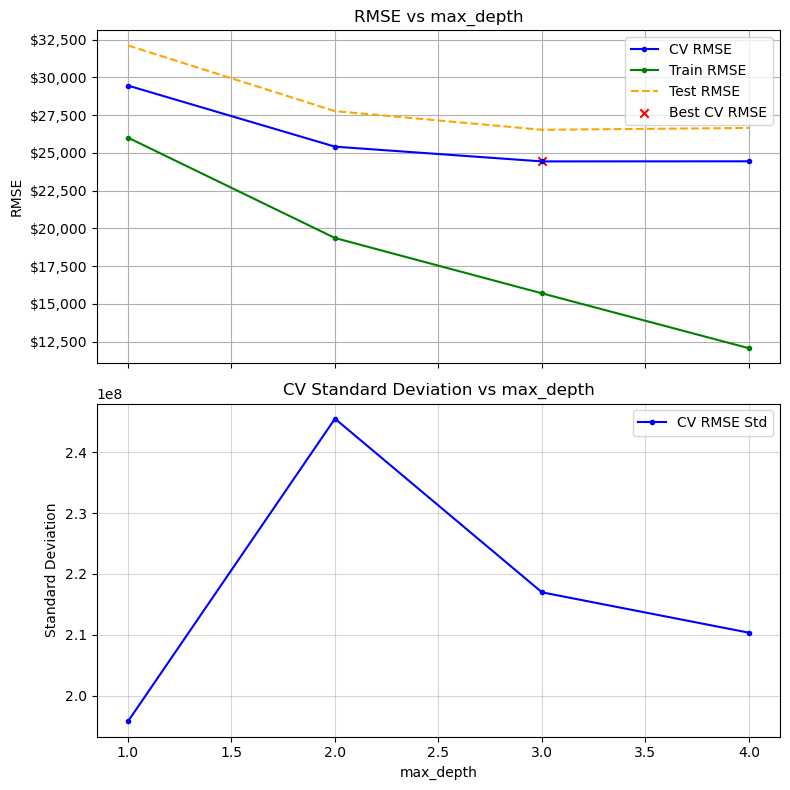

Execution Time: 00:00:39
Best RMSE 24438.312169184534
Best Parameters after sweeping max_depth: {'n_estimators': 100, 'max_features': None, 'max_depth': 3, 'random_state': 42, 'MSE_found': 597231101.6785129}


In [120]:
# Copy the default parameters
Parameters_GB = Default_Parameters_Random_Forests.copy()
Parameters_GB.pop('bootstrap', None)

# Define a range of values for n_estimators
max_depth_list = np.arange(1, 5, 1)  

# Sweep n_estimators
Parameters_GB = sweep_parameter(
    model=GradientBoostingRegressor,
    Parameters=Parameters_GB,
    param='max_depth',
    parameter_list=max_depth_list,
)

print("Best RMSE", Parameters_GB['MSE_found']**0.5)

print("Best Parameters after sweeping max_depth:", Parameters_GB)

### Problem 3.B Graded Answer

In [136]:
# TODO:  Set the variable to best CV RMSE score found after Part 3.B (it may not be different than Part 3.A)

a3b = 23794.08098801119                               # Just to get it to run without error; your answer here           

print(f'a3b = ${a3b:,.2f}')              # Do not change this line, and DO NOT print anything else in this cell

a3b = $23,794.08


### **Part 3.C: Use `GridSearchCV` for Exhaustive Search**  

In [129]:
# Your code here -- Add as many code cells as necessary
start=time.time()

# Define the model
GR_model = GradientBoostingRegressor(random_state=random_state)

# Define the parameter grid
param_grid = {
    'learning_rate': np.linspace(0.14, 0.18, 5),
    'n_estimators': range(300, 341, 10), 
    'max_depth': [3],
    'max_features': range(11, 15, 1),

    # 'bootstrap': [True, False]
}

# Use GridSearchCV to find the best parameters
search = GridSearchCV(
    estimator=GR_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # MSE but negated for maximization by GridSearchCV
    cv=RepeatedKFold(random_state=random_state),  # Use RepeatedKFold
    n_jobs=-1,  # Use all available cores
)

search.fit(X_train, y_train)

# Extract results into a DataFrame
results = pd.DataFrame(search.cv_results_)

# Sort results by mean_test_score (ascending order)
sorted_value = np.argsort(-results['mean_test_score'])

# Print the top 10 parameter combinations
for rank, index in enumerate(sorted_value[:10], start=1):
    parameter = results['params'][index]  # Use 'params' instead of 'parameter'
    mean_score = results['mean_test_score'][index]  # Convert back to positive MSE
    std_score = results['std_test_score'][index]
    rmse = np.sqrt(-mean_score)

    print(f"Rank {rank}: Parameters: {parameter}, Mean Test Score: {mean_score}, std: {std_score}, RMSE: {rmse:.4f}")

# End the timer
end = time.time()

# Print execution time
print(f"Execution Time: {end - start:.2f} seconds")



Rank 1: Parameters: {'learning_rate': 0.16, 'max_depth': 3, 'max_features': 11, 'n_estimators': 340}, Mean Test Score: -543472236.1905476, std: 187678913.46339017, RMSE: 23312.4910
Rank 2: Parameters: {'learning_rate': 0.16, 'max_depth': 3, 'max_features': 11, 'n_estimators': 330}, Mean Test Score: -543889054.9137597, std: 187860042.30405962, RMSE: 23321.4291
Rank 3: Parameters: {'learning_rate': 0.16, 'max_depth': 3, 'max_features': 11, 'n_estimators': 320}, Mean Test Score: -544369709.255648, std: 187393288.37084395, RMSE: 23331.7318
Rank 4: Parameters: {'learning_rate': 0.16, 'max_depth': 3, 'max_features': 11, 'n_estimators': 310}, Mean Test Score: -544918166.6148765, std: 187051210.20737773, RMSE: 23343.4823
Rank 5: Parameters: {'learning_rate': 0.16, 'max_depth': 3, 'max_features': 11, 'n_estimators': 300}, Mean Test Score: -545470152.5328997, std: 187208188.63927868, RMSE: 23355.3025
Rank 6: Parameters: {'learning_rate': 0.14, 'max_depth': 3, 'max_features': 11, 'n_estimators': 

### Problem 3.C Graded Answer

In [135]:
# TODO:  Set the variable to best CV RMSE score found in Part C (it may not be different than Parts A and B)

a3c = 23312.4910                             # Just to get it to run without error; your answer here           

print(f'a3c = ${a3c:,.2f}')              # Do not change this line, and DO NOT print anything else in this cell

a3c = $23,312.49


### **Part 3.D: Evaluate Model Generalization**  


### Problem 3.D Graded Answer

In [134]:
# TODO:  Which of options 1, 2, or 3 did you choose?

a3d = 3                                # Should be integer 1, 2, or 3          

print(f'a3d = {a3d}')                    # Do not change this line, and DO NOT print anything else in this cell

a3d = 3


### Problem 3.D Non-Graded Answer but Please Do It

Describe in a couple of sentences how your examination of the plots led to your decision. (You'll be expected to answer many such questions when you do your project, so this is good practice, and I'll read as many of your answers as I can.)

Your Answer: It is hard to tell which model is the best, as the differences is limited. I go wieh grid search result, because it consider more than one paramaters, and do it "automatically"






### **Part 3.E: Report the Test Score of the Best Model**  
Once you have selected the best model, **report its final test score** and answer the graded question.   


In [132]:
# Run your best model here on the test data and print out the resulting test RMSE. 
final_parameters = {
    'learning_rate': 0.16,
    'n_estimators': 340,            # Number of base estimators in the ensemble
    'max_depth' : 3,           # Fraction of samples to draw for each base estimator
    'max_features': 11,           # Fraction of features to consider for each estimator
    # 'bootstrap'   : True,          # Use bootstrap samples when building estimators
    'random_state': 42,            # Ensures reproducibility
    # 'MSE_found'   : float('inf')   # Used for tracking the best MSE during parameter sweeps, to record result of these parameter choices
                                   # Initialized to inf in case want to use this to record best MSE found so far in a sequence of parameter choices
}

_,_,_,test_MSE=run_model(GradientBoostingRegressor, X_train, y_train, X_test, y_test, n_repeats=1, n_jobs=-1, **final_parameters)

RMSE=test_MSE**0.5
print(f"RMSE = ${RMSE:.2f}")

RMSE = $25742.75


### Problem 3.E Graded Answer

In [133]:
# TODO:  Assign the variable to the test RMSE of the model you selected in Part E

a3e = 25742.75                                # Just to get it to run without error; your answer here           

print(f'a3e = ${a3e:,.2f}')              # Do not change this line, and DO NOT print anything else in this cell

a3e = $25,742.75


## Appendix 1: Which `BaggingRegressor` parameters are most important?

When exploring ensemble methods like `BaggingRegressor`, it's best to focus at first on the parameters that directly influence both the behavior of the individual base estimators and the overall ensemble performance. Here is an approximate ordering of the parameters from most significant to least. In this homework, we will experiment with the top **four** parameters.

---

**Most Important Parameters**

1. **n_estimators** (default: **10**)  
   *Determines the number of base estimators in the ensemble. Increasing this number can reduce variance and improve performance, though it comes with higher computational cost.*

2. **max_samples** (default: **1.0**)  
   *Specifies the number (or fraction) of samples to draw from the training set for each base estimator. This is crucial for controlling the diversity of the estimators and can directly affect bias and variance.*

3. **max_features** (default: **1.0**)  
   *Specifies the number (or fraction) of features to consider when training each base estimator. Adjusting this parameter can help manage overfitting by limiting the complexity of each individual estimator.*

4. **bootstrap** (default: **True**)  
   *Indicates whether samples are drawn with replacement. Bootstrap sampling introduces randomness into the training process, leading to more diverse estimators and often improved ensemble performance.*

---

**Less Important Parameters**

5. **base_estimator** (default: **None**)  
   *Defines the underlying estimator to be used. If set to `None`, BaggingRegressor defaults to using a DecisionTreeRegressor. Experimenting with different base estimators can provide valuable insights into model performance.*

6. **oob_score** (default: **False**)  
   *If enabled, the model uses out-of-bag samples to estimate the generalization error, providing an internal validation metric without the need for a separate validation set.*

7. **bootstrap_features** (default: **False**)  
   *Specifies whether features are sampled with replacement. This additional layer of randomness can further increase estimator diversity, though its impact is typically less significant than sample bootstrapping.*


## Appendix 2: Which `RandomForestRegressor` parameters are most important?

We will focus on the top **four** parameters in this list for `RandomForestRegressor`. 

---

**Most Important Parameters**

1. **n_estimators** (default: **100**)  
   *Determines the number of trees in the forest. Increasing this number generally improves performance and model stability, albeit with higher computational cost.*

2. **max_features** (default: **None**)  
   *Specifies the number of features to consider when looking for the best split. Adjusting this can help manage the bias-variance trade-off and affect the diversity among the trees.*

3. **max_depth** (default: **None**)  
   *Limits the depth of each tree. Restricting the maximum depth is an effective way to control overfitting and reduce the complexity of the model.*

4. **bootstrap** (default: **True**)  
   *Indicates whether bootstrap samples are used when building trees. Enabling bootstrap sampling introduces randomness into the training process, which can improve the generalization of the ensemble.*

---

**Less Important Parameters**

5. **min_samples_split** (default: **2**)  
   *Defines the minimum number of samples required to split an internal node. Tuning this parameter affects how the tree grows, influencing its granularity and robustness.*

6. **min_samples_leaf** (default: **1**)  
   *Specifies the minimum number of samples that must be present in a leaf node. This parameter ensures that leaves are not created with too few samples, which can help mitigate overfitting.*

7. **oob_score** (default: **False**)  
   *If enabled, uses out-of-bag samples to estimate the generalization error, providing an internal validation measure without the need for a separate validation set.*

8. **criterion** (default: **'squared_error'**)  
   *Determines the function used to measure the quality of a split. While its effect is typically subtle, experimenting with this parameter can reveal how different error metrics impact performance.*



## Appendix 3: Which `GradientBoostingRegressor` parameters are most important?

We will focus on the top **four** parameters in this list for `GradientBoostingRegressor`. 

---

**Most Important Parameters**

1. **learning_rate** (default: **0.1**)  
   *Controls the contribution of each individual tree. A lower learning rate generally requires more trees but can lead to improved generalization.*

2. **n_estimators** (default: **100**)  
   *Specifies the number of boosting stages (i.e., the number of trees in the ensemble). More estimators can improve performance but also increase the risk of overfitting if not tuned properly.*

3. **max_depth** (default: **3**)  
   *Limits the depth of the individual regression trees. Restricting the depth helps control overfitting and reduces the complexity of each base learner.*

4. **max_features** (default: **None**)  
   *Controls the number of features to consider when looking for the best split. Adjusting this can influence the bias-variance trade-off of the model.*
   
---

**Less Important Parameters**

5. **min_samples_split** (default: **2**)  
   *Defines the minimum number of samples required to split an internal node. This parameter controls the growth of each tree and can prevent overly specific splits.*

6. **min_samples_leaf** (default: **1**)  
   *Specifies the minimum number of samples that must be present in a leaf node. This helps in ensuring that trees do not become too tailored to the training data.*

7. **max_leaf_nodes** (default: **None**)  
    *An optional parameter that sets a maximum number of leaf nodes for each tree. This can provide an additional way to control the complexity of the model.*

8. **subsample** (default: **1.0**)  
   *Determines the fraction of samples used for fitting each individual tree. Values less than 1.0 introduce randomness into the boosting process, which can help reduce overfitting.*

9. **loss** (default: **'squared_error'**)  
   *Determines the loss function to be optimized during training. Different loss functions can be used depending on the specific characteristics of the regression problem.*





## Appendix 4: Tips on Tuning Complicated Models

### Using `sweep_parameters` for Single-Parameter Exploration

1. **Purpose**  
   - The function `sweep_parameters` automates the process of iterating over a list of parameter values (e.g., `n_estimators` in a random forest) and training a model for each value.
   - It then computes and plots, for each value in the specified range:
     - **Training MSE**: How well the model fits the training data.  
     - **Cross-Validation (CV) MSE**: An estimate of how well the model generalizes, averaged over multiple folds (and possibly multiple repeats).  
     - **Test MSE**: If you have a dedicated test set, this provides a final check of out-of-sample performance.  
     - **Std of CV Scores**: The standard deviation across cross-validation folds (and repeats), indicating how stable or variable the model performance is.

2. **Interpretation of the Plots**  
   - **Training MSE vs. Parameter Value**:  
     Helps you see when the model is overfitting (training MSE much lower than CV MSE) or underfitting (training MSE is high).
   - **CV MSE vs. Parameter Value**:  
     Typically your key metric for choosing the parameter setting. Look for a valley in this curve.
   - **Test MSE vs. Parameter Value**:  
     The precise values here are dependent on the random split of training and testing sets; we include it so that we may examine the **gap** between CV MSE and test MSE (see Appendix 5). 
   - **Std of CV Scores vs. Parameter Value**:  
     Large standard deviation means the model’s performance is inconsistent across folds (and repeats). You may want to pick a parameter setting that not only has a low mean CV MSE but also a lower standard deviation for more reliable performance.
   - **Beware of the Scale of the Plots!**
     The plots are drawn to fit the values, and the scale of the y-axis may vary quite a lot!  Therefore, you can not just "eyeball" a curve and make quick decisions that, say, the std of the CV score indicates something important. **It depends on the scale of the y-axis.**  If the curve(s) are relatively flat, the differences shown may in reality be quite small!  Just be careful to observe both the shape and the scale of the plots. 
3. **Sweeping Strategy**  
   - **Coarse to Fine**: Start with wide ranges and larger steps (e.g., 100–1000 in increments of 100). Narrow down once you see the region where the CV MSE is lowest. Then reduce step sizes in that region (e.g., steps of 25 or 10).
   - **Stop Early if Converged**: If the CV MSE difference between 1400 and 1405 `n_estimators` is negligible, further fine-tuning is unlikely to yield real improvement.

**Note:** We will not be using early stopping in this homework, because we are still learning how to interpret model performance, but with further experience, you may find that early stopping will help you zero in on the best models. 

---

### Adjusting Repeated Cross-Validation

1. **Why Repeat?**  
   - Cross-validation is already a good measure of generalization. However, it’s still sensitive to how the data is split into folds. Repeating cross-validation with different random folds provides a more robust estimate (reducing the variance of the CV score).

2. **When to Increase Repeats**  
   - **Early Sweeps**: Use 1 or 2 repeats when you are scanning large ranges of your parameter. The goal is speed and a rough idea of where the “sweet spot” is, so you don’t want to spend too much computation time on many repeats.
   - **Narrowed Sweeps**: Once you have focused on a smaller interval (e.g., 1300–1500 in increments of 25 for `n_estimators`), increase repeats to 5 (ok) or 10 (ideal). This gives you a more stable estimate and helps confirm the final optimal setting with greater confidence.

3. **Trade-Offs**  
   - **Computation**: Each extra repeat multiplies the total training time. If you have limited computational resources, keep the repeats modest until you are zeroing in on a smaller range.
   - **Stability**: More repeats lower the variance of your CV estimate. If you see widely fluctuating performance across folds, use more repeats to gauge if it’s truly unstable or just a byproduct of the data splits.

---

### Tips for a Smooth Workflow

1. **Plot and Observe**  
   Always visualize the training/CV/test MSE vs. parameter and the CV std plots. Look for patterns of overfitting or underfitting, and watch the standard deviation for instability.

2. **Document Iterations using Parameter Dictionaries**  
   In the video notebook for Week 7 on Gradient Boosting, we stored the parameter dictionaries in a list; you may wish to do something similar, or find some other way of recording your results. 

3. **Scale Up Gradually**  
   Start simply (fewer repeats, coarse parameter steps), refine as you learn more, and only then use heavier computations (more repeats, fine steps).

4. **Use `GridSearchCV` Judiciously**  
   Grid and random search are powerful tools, but can lead to hours of computation--and without a progress bar to tell you how far you've gotten! Use these tools to refine and verify your search after you understand the search space through plotting and visualization. The same "scale up gradually" approach should be used here as well. 

5. **Take Advantage of Parallelism with `n_jobs=-1`**  
   Many scikit-learn functions, such as cross-validation and grid search routines, allow you to specify the `n_jobs` parameter. We have set the default at `n_jobs=-1` to use all available CPU cores to speed up processing.  
   - **If You See Warnings**: Sometimes, you may get a message like “A worker stopped while some jobs were still running.” This can happen if your system is running out of memory or hitting other resource limits. Mostly you can ignore these.  But if you are concerned, reduce the number of jobs (e.g., `n_jobs=4`) to reduce the load.  You can also track the system load using the Activity Monitor (on Mac) or Task Manager (on PC). 
   - **Utilize a Robust Environment**: If you need more parallel processing power, consider using a computing environment such as Google Colab, which offers additional CPU cores to handle more intensive jobs efficiently.

By combining the coarse-to-fine parameter sweeping with increasing repeats as you zero in on the most promising configurations, you balance computational efficiency with the need for robust, stable model performance estimates.

## Appendix 5:  Model Selection:  When is a model overfitting? Which model to choose?

- **Minimize Mean CV MSE:** Aim for the model configuration with the lowest mean CV MSE as a primary indicator of good generalization.
- **Stable CV Performance:** Choose a model where the CV MSE either
  - Reaches a minimum and then starts to increase, or
  - Plateaus—indicating additional improvements are marginal—rather than a continuously decreasing trend that may signal overfitting.
- **Gap Analysis:** Watch out for an *increasing gap* between the mean CV MSE and testing MSE. A growing gap can be a sign of overfitting to the training data. Do not worry about the *size* of the gap, which will primarily be due to the random split between training and testing sets; it is the *change* in the gap between the two that is most significant. 
- **CV Score Consistency:** Favor models with a lower standard deviation in CV scores, as this reflects more consistent performance across different data splits.
- **Be Aware of the Scale:** You need to look not only at the shape of the curves, but the scale of the y-axis, particularly with the std of the CV scores.  Beware of assuming that there is a significant difference unless you take account of the actual values!  